# Multilingual Dataset Results

## Get Results

In [1]:
import json
import matplotlib.pyplot as plt


def read_file(f):
    with open(f, "r") as f:
        return json.load(f)

In [2]:
models = {
    "xglm": [
        "xglm-564M",
        "xglm-1.7B",
        "xglm-2.9B",
        "xglm-4.5B",
        "xglm-7.5B",
    ],
    "bloom": [
        "bloom-560m",
        "bloom-1b1",
        "bloom-1b7",
        "bloom-3b",
        "bloom-7b1",
    ],
    "llama": [
        "llama-7B",
        "llama-13B",
        "llama-30B",
        "llama-65B",
    ],
}


In [3]:
datasets = ["xstory_cloze", "xcopa", "xwinograd", "xnli", "pawsx", "mgsm"]
datasets_mt = ["xstory_cloze-mt", "xcopa-mt", "xnli-mt", "xnli-mt-all", "pawsx-mt", "mgsm-mt"]
all_datasets = datasets + datasets_mt

In [4]:
model_sizes = {
    "xglm": [0.56, 1.7, 2.9, 4.5, 7.5],
    "bloom": [0.56, 1.1, 1.7, 3.0, 7.1],
    "llama": [7.0, 13.0, 30.0, 65.0],
}


In [5]:
from collections import defaultdict

def get_results(results):
    res = {k: round(v["acc"] * 100, 1) for k, v in results.items()}
    res = dict(sorted(res.items()))
    task_names = list(res.keys())
    results_dataset = defaultdict(dict)
    dataset_names = set([task[:-3] for task in task_names])
    for dataset_name in dataset_names:
        results_dataset[dataset_name] = defaultdict(dict)
    for task in task_names:
        dataset_name = task[:-3]
        lang = task[-2:]
        results_dataset[dataset_name][lang] = res[task]
    for dataset_name, resu in results_dataset.items():
        results_dataset[dataset_name]["avg"] = round(sum(resu.values()) / len(resu), 1)
    return results_dataset

In [6]:
from collections import defaultdict

all_results = defaultdict(dict)
for model, names in models.items():
    for dataset in all_datasets:
        for name in names:
            shots = 8 if dataset in ["mgsm", "mgsm-mt"] else 0
            output = read_file(
                f"../results/{model}/{name}/{name}_{dataset}_{shots}-shot.json"
            )
            results = get_results(output["results"])
            for dataset_name in results:
                if dataset_name not in all_results:
                    all_results[dataset_name] = defaultdict(dict)
                all_results[dataset_name][name].update(results[dataset_name])

In [7]:
all_results.keys()

dict_keys(['xstory_cloze', 'xcopa', 'xwinograd', 'xnli', 'pawsx', 'mgsm', 'xstory_cloze-mt_nllb-200-1.3B', 'xstory_cloze-mt_nllb-200-3.3B', 'xstory_cloze-mt_nllb-200-distilled-600M', 'xstory_cloze-mt_nllb-200-distilled-1.3B', 'xcopa-mt_nllb-200-distilled-600M', 'xcopa-mt_nllb-200-3.3B', 'xcopa-mt_nllb-200-1.3B', 'xcopa-mt_nllb-200-distilled-1.3B', 'xnli-mt_nllb-200-3.3B', 'xnli-mt_nllb-200-distilled-600M', 'xnli-mt_nllb-200-distilled-1.3B', 'xnli-mt_nllb-200-1.3B', 'pawsx-mt_nllb-200-distilled-600M', 'pawsx-mt_nllb-200-3.3B', 'pawsx-mt_nllb-200-1.3B', 'pawsx-mt_nllb-200-distilled-1.3B', 'mgsm-mt_nllb-200-distilled-600M', 'mgsm-mt_nllb-200-3.3B', 'mgsm-mt_nllb-200-distilled-1.3B', 'mgsm-mt_nllb-200-1.3B'])

In [8]:
all_results


defaultdict(dict,
            {'xstory_cloze': defaultdict(dict,
                         {'xglm-564M': {'ar': 50.1,
                           'en': 60.6,
                           'es': 55.1,
                           'eu': 53.1,
                           'hi': 52.3,
                           'id': 54.0,
                           'my': 51.5,
                           'ru': 56.2,
                           'sw': 53.1,
                           'te': 55.9,
                           'zh': 53.3,
                           'avg': 54.1},
                          'xglm-1.7B': {'ar': 52.5,
                           'en': 64.3,
                           'es': 59.2,
                           'eu': 56.1,
                           'hi': 55.8,
                           'id': 58.0,
                           'my': 53.8,
                           'ru': 59.8,
                           'sw': 56.0,
                           'te': 58.0,
                           'zh': 56.2,
          

## Results by Language

In [12]:
def plot_size_df(df, model_sizes, title):
    dft = df.T
    dft["size"] = model_sizes
    dft.plot(x="size", marker="o")
    plt.title(title)
    plt.xticks(model_sizes, model_sizes, rotation="vertical");
    plt.show()

In [ ]:
results = all_results["xstory_cloze"]

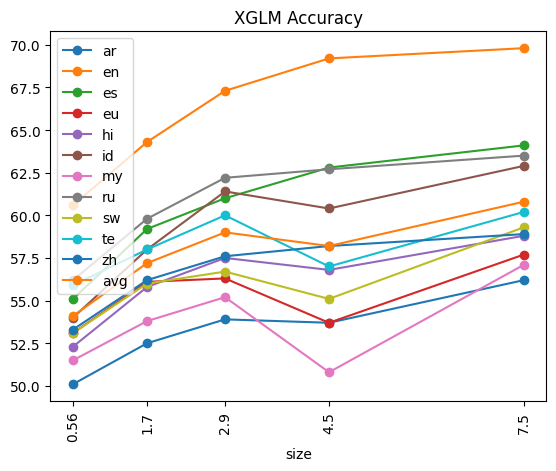

In [13]:
plot_size_df(results.T[models["xglm"]], model_sizes["xglm"], "XGLM Accuracy")

In [14]:
results

,ar,en,es,eu,hi,id,my,ru,sw,te,zh,avg
xglm-564M,50.1,60.6,55.1,53.1,52.3,54.0,51.5,56.2,53.1,55.9,53.3,54.1
xglm-1.7B,52.5,64.3,59.2,56.1,55.8,58.0,53.8,59.8,56.0,58.0,56.2,57.2
xglm-2.9B,53.9,67.3,61.0,56.3,57.5,61.4,55.2,62.2,56.7,60.0,57.6,59.0
xglm-4.5B,53.7,69.2,62.8,53.7,56.8,60.4,50.8,62.7,55.1,57.0,58.2,58.2
xglm-7.5B,56.2,69.8,64.1,57.7,58.8,62.9,57.1,63.5,59.3,60.2,58.9,60.8
bloom-560m,52.1,61.2,55.9,53.6,55.0,55.5,47.2,49.2,49.8,55.7,54.5,53.6
bloom-1b1,52.9,62.5,58.3,54.3,55.5,57.9,46.2,48.2,50.6,56.4,58.0,54.6
bloom-1b7,55.0,64.7,60.8,54.9,56.8,59.8,47.3,50.4,52.3,56.5,58.2,56.1
bloom-3b,56.6,66.8,64.1,55.7,57.6,60.8,46.6,50.7,53.0,58.2,60.9,57.4
bloom-7b1,58.6,70.7,66.1,57.2,60.6,64.5,49.0,52.7,53.9,57.4,61.9,59.3


## Results by Dataset

In [15]:
import pandas as pd

model_sizes_all = model_sizes["xglm"] + model_sizes["bloom"] + model_sizes["llama"]

def get_dataframes(all_results, datasets):
    for dataset in datasets:
        results = pd.DataFrame(all_results[dataset]).T
        results["dataset"] = dataset
        results["model"] = [model.split("-")[0] for model in results.index]
        results["size"] = model_sizes_all
        yield results

In [16]:
def plot_size_df_models(df):
    df.set_index("size", inplace=True)
    df.groupby("model")["avg"].plot(
        x="size", y="acc", title=list(df["dataset"])[0], legend=True, marker="o"
    )
    # x axis in log scale
    plt.xscale("log")
    plt.xticks(model_sizes_all, model_sizes_all, rotation="vertical");
    plt.show()

In [19]:
datasets_all = list(all_results.keys())
dfs_mt = get_dataframes(all_results, datasets_all)


,ar,en,es,eu,hi,id,my,ru,sw,te,zh,avg,dataset,model,size
xglm-564M,50.1,60.6,55.1,53.1,52.3,54.0,51.5,56.2,53.1,55.9,53.3,54.1,xstory_cloze,xglm,0.56
xglm-1.7B,52.5,64.3,59.2,56.1,55.8,58.0,53.8,59.8,56.0,58.0,56.2,57.2,xstory_cloze,xglm,1.70
xglm-2.9B,53.9,67.3,61.0,56.3,57.5,61.4,55.2,62.2,56.7,60.0,57.6,59.0,xstory_cloze,xglm,2.90
xglm-4.5B,53.7,69.2,62.8,53.7,56.8,60.4,50.8,62.7,55.1,57.0,58.2,58.2,xstory_cloze,xglm,4.50
xglm-7.5B,56.2,69.8,64.1,57.7,58.8,62.9,57.1,63.5,59.3,60.2,58.9,60.8,xstory_cloze,xglm,7.50
bloom-560m,52.1,61.2,55.9,53.6,55.0,55.5,47.2,49.2,49.8,55.7,54.5,53.6,xstory_cloze,bloom,0.56
bloom-1b1,52.9,62.5,58.3,54.3,55.5,57.9,46.2,48.2,50.6,56.4,58.0,54.6,xstory_cloze,bloom,1.10
bloom-1b7,55.0,64.7,60.8,54.9,56.8,59.8,47.3,50.4,52.3,56.5,58.2,56.1,xstory_cloze,bloom,1.70
bloom-3b,56.6,66.8,64.1,55.7,57.6,60.8,46.6,50.7,53.0,58.2,60.9,57.4,xstory_cloze,bloom,3.00
bloom-7b1,58.6,70.7,66.1,57.2,60.6,64.5,49.0,52.7,53.9,57.4,61.9,59.3,xstory_cloze,bloom,7.10


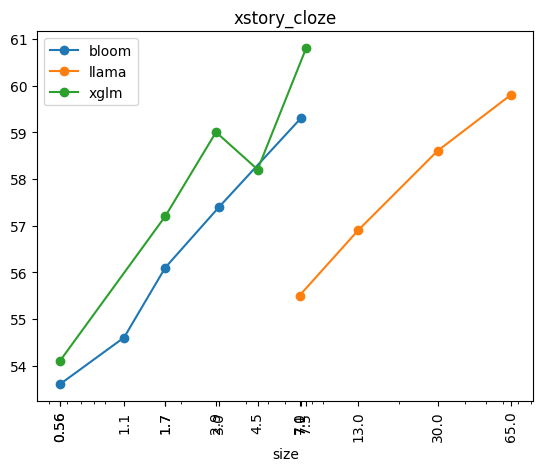

,et,ht,id,it,qu,sw,ta,th,tr,vi,zh,avg,dataset,model,size
xglm-564M,55.6,55.0,57.2,53.8,49.2,53.2,56.2,55.2,54.4,58.4,55.6,54.9,xcopa,xglm,0.56
xglm-1.7B,56.8,55.8,64.6,54.0,52.2,56.6,55.2,58.2,53.4,63.0,58.0,57.1,xcopa,xglm,1.70
xglm-2.9B,58.2,55.8,66.8,60.2,50.2,58.8,54.2,57.0,56.6,65.2,60.0,58.5,xcopa,xglm,2.90
xglm-4.5B,55.0,51.2,67.0,61.6,50.0,56.2,55.6,55.2,57.2,66.0,61.6,57.9,xcopa,xglm,4.50
xglm-7.5B,61.2,57.4,69.4,63.6,48.8,60.0,54.4,59.4,58.4,70.2,63.8,60.6,xcopa,xglm,7.50
bloom-560m,49.0,50.2,59.2,50.8,50.2,51.6,55.8,54.4,53.0,61.0,58.6,54.0,xcopa,bloom,0.56
bloom-1b1,50.6,53.0,64.8,50.8,51.2,54.4,57.0,53.2,53.0,62.4,59.4,55.4,xcopa,bloom,1.10
bloom-1b7,47.4,50.4,63.2,52.6,50.6,51.8,56.6,53.2,52.8,65.8,61.4,55.1,xcopa,bloom,1.70
bloom-3b,49.2,50.2,69.2,51.6,50.6,51.4,58.0,52.6,53.4,68.8,62.0,56.1,xcopa,bloom,3.00
bloom-7b1,48.2,50.8,69.8,52.8,50.8,51.6,59.2,55.4,51.2,70.8,65.2,56.9,xcopa,bloom,7.10


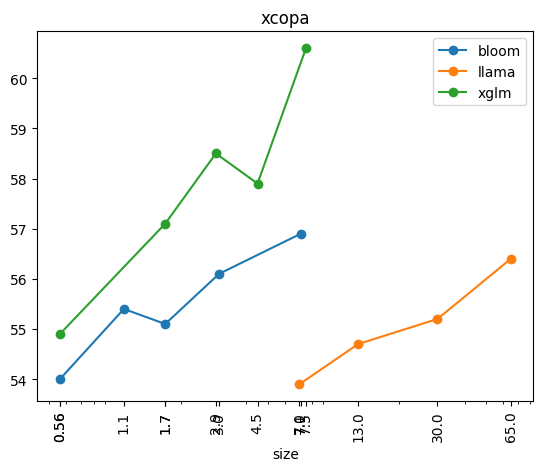

,en,fr,jp,pt,ru,zh,avg,dataset,model,size
xglm-564M,62.6,57.8,54.5,58.6,59.0,65.7,59.7,xwinograd,xglm,0.56
xglm-1.7B,71.1,60.2,60.6,63.9,59.7,69.8,64.2,xwinograd,xglm,1.70
xglm-2.9B,75.6,59.0,64.7,66.2,62.9,71.6,66.7,xwinograd,xglm,2.90
xglm-4.5B,76.3,60.2,62.7,64.6,62.2,70.6,66.1,xwinograd,xglm,4.50
xglm-7.5B,79.5,65.1,65.0,67.3,63.2,72.8,68.8,xwinograd,xglm,7.50
bloom-560m,65.9,60.2,53.0,60.1,49.2,67.7,59.4,xwinograd,bloom,0.56
bloom-1b1,70.0,66.3,52.9,63.1,54.3,69.2,62.6,xwinograd,bloom,1.10
bloom-1b7,74.7,68.7,54.1,63.5,52.4,69.6,63.8,xwinograd,bloom,1.70
bloom-3b,79.1,71.1,56.6,70.3,53.7,73.6,67.4,xwinograd,bloom,3.00
bloom-7b1,82.2,71.1,58.5,76.8,56.8,74.4,70.0,xwinograd,bloom,7.10


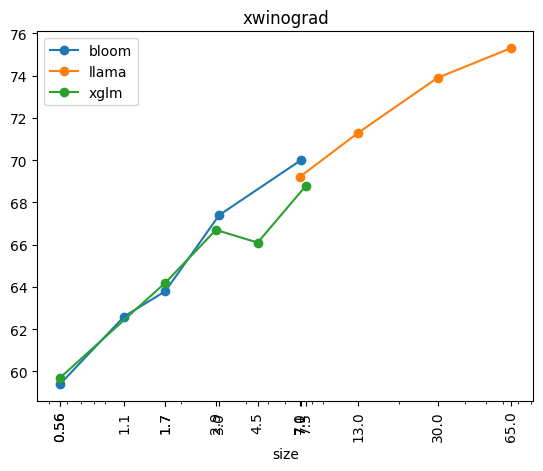

,ar,bg,de,el,en,es,fr,hi,ru,sw,th,tr,ur,vi,zh,avg,dataset,model,size
xglm-564M,33.4,41.3,44.5,39.6,48.3,42.0,45.5,38.7,44.6,36.1,38.8,40.2,34.5,38.5,33.5,40.0,xnli,xglm,0.56
xglm-1.7B,33.5,44.7,45.3,40.1,49.7,43.6,45.7,42.6,46.0,42.0,41.7,43.0,39.5,45.0,33.8,42.4,xnli,xglm,1.70
xglm-2.9B,33.7,46.0,48.3,41.4,51.1,46.7,45.0,44.0,45.3,44.4,42.0,45.0,40.1,46.0,34.8,43.6,xnli,xglm,2.90
xglm-4.5B,33.6,45.6,47.1,39.8,53.6,47.7,47.3,42.5,46.1,39.6,39.7,44.9,37.5,45.9,34.8,43.0,xnli,xglm,4.50
xglm-7.5B,33.4,44.9,49.0,40.7,53.9,47.7,46.9,47.2,46.3,45.8,43.7,46.3,42.1,46.3,35.4,44.6,xnli,xglm,7.50
bloom-560m,33.4,33.4,34.8,33.3,49.5,45.2,45.3,40.8,34.0,33.2,33.6,33.4,37.1,40.5,34.0,37.4,xnli,bloom,0.56
bloom-1b1,33.9,34.1,39.6,34.0,51.5,48.0,47.1,42.3,40.5,35.3,33.8,34.8,37.3,44.5,36.2,39.5,xnli,bloom,1.10
bloom-1b7,33.6,35.4,40.6,34.0,50.1,47.8,48.2,44.0,39.3,34.5,33.4,34.9,40.5,46.2,36.2,39.9,xnli,bloom,1.70
bloom-3b,33.4,37.9,40.4,33.2,53.4,49.1,49.2,45.5,41.4,35.8,33.4,33.8,40.0,46.5,37.4,40.7,xnli,bloom,3.00
bloom-7b1,33.8,39.7,39.9,35.7,53.9,48.7,49.7,46.5,43.1,37.9,35.0,35.1,42.1,47.0,35.4,41.6,xnli,bloom,7.10


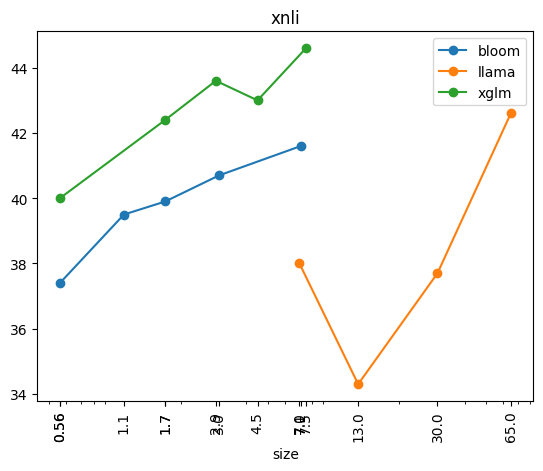

,de,en,es,fr,ja,ko,zh,avg,dataset,model,size
xglm-564M,49.1,50.6,52.5,50.8,44.1,46.2,47.8,48.7,pawsx,xglm,0.56
xglm-1.7B,57.6,52.6,53.8,47.3,46.1,51.4,48.1,51.0,pawsx,xglm,1.70
xglm-2.9B,50.6,54.8,53.1,49.7,50.9,46.8,53.7,51.4,pawsx,xglm,2.90
xglm-4.5B,52.6,55.4,51.0,51.6,47.8,49.1,54.6,51.7,pawsx,xglm,4.50
xglm-7.5B,55.9,58.9,52.8,51.8,52.0,46.0,51.3,52.7,pawsx,xglm,7.50
bloom-560m,52.8,52.0,53.2,47.9,44.9,51.9,45.2,49.7,pawsx,bloom,0.56
bloom-1b1,46.9,52.4,51.5,46.2,48.4,49.9,48.9,49.2,pawsx,bloom,1.10
bloom-1b7,48.8,48.9,51.3,46.2,44.7,45.8,45.4,47.3,pawsx,bloom,1.70
bloom-3b,54.6,56.8,56.4,47.6,44.6,46.3,47.1,50.5,pawsx,bloom,3.00
bloom-7b1,52.8,61.3,59.4,50.9,45.5,45.1,47.3,51.8,pawsx,bloom,7.10


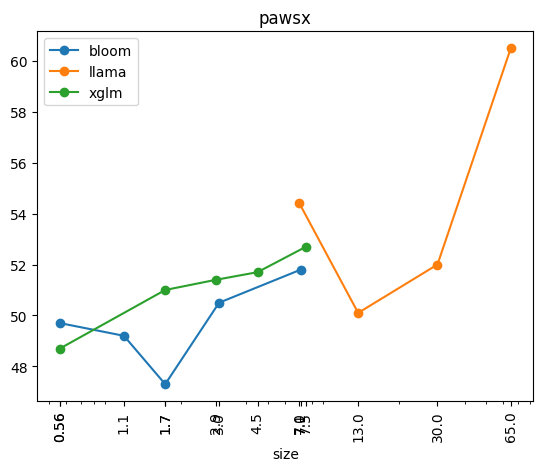

,bn,de,en,es,fr,ja,ru,sw,te,th,zh,avg,dataset,model,size
xglm-564M,1.6,0.8,1.6,1.2,1.6,4.0,0.4,2.4,0.8,1.2,3.6,1.7,mgsm,xglm,0.56
xglm-1.7B,0.8,1.2,0.8,2.8,0.8,2.8,1.2,2.8,1.2,2.4,1.6,1.7,mgsm,xglm,1.70
xglm-2.9B,0.0,1.6,2.4,1.6,0.8,2.0,2.4,2.4,2.4,0.0,1.2,1.5,mgsm,xglm,2.90
xglm-4.5B,0.0,2.0,0.8,1.6,0.4,0.4,2.4,2.8,0.8,0.0,1.6,1.2,mgsm,xglm,4.50
xglm-7.5B,0.0,1.2,0.0,0.0,0.0,0.8,3.2,0.8,1.2,2.4,2.0,1.1,mgsm,xglm,7.50
bloom-560m,3.2,1.2,2.8,2.8,1.6,1.2,2.0,0.8,2.4,0.0,2.0,1.8,mgsm,bloom,0.56
bloom-1b1,2.0,2.0,0.8,2.4,2.4,0.4,2.0,2.8,2.0,0.0,2.8,1.8,mgsm,bloom,1.10
bloom-1b7,2.0,4.0,1.2,2.4,3.2,2.8,2.4,1.6,1.6,0.0,2.8,2.2,mgsm,bloom,1.70
bloom-3b,2.0,1.2,3.2,2.8,2.0,2.4,0.8,2.8,2.4,0.0,3.2,2.1,mgsm,bloom,3.00
bloom-7b1,4.8,0.4,5.2,5.2,4.0,1.2,4.0,2.8,4.4,0.0,4.8,3.3,mgsm,bloom,7.10


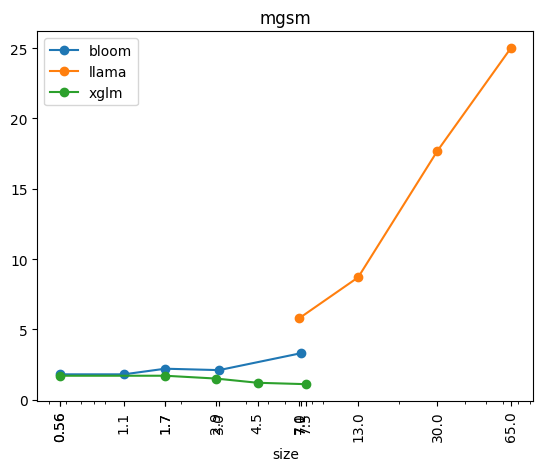

,ar,es,eu,hi,id,my,ru,sw,te,zh,avg,dataset,model,size
xglm-564M,56.9,57.6,59.6,58.5,56.9,56.1,59.1,56.1,59.8,54.9,57.5,xstory_cloze-mt_nllb-200-1.3B,xglm,0.56
xglm-1.7B,59.6,61.0,61.6,61.4,60.8,57.4,61.6,59.0,60.8,59.1,60.2,xstory_cloze-mt_nllb-200-1.3B,xglm,1.70
xglm-2.9B,60.9,63.5,62.3,63.8,61.8,59.4,63.9,61.5,61.8,59.2,61.8,xstory_cloze-mt_nllb-200-1.3B,xglm,2.90
xglm-4.5B,62.6,64.3,63.6,64.6,61.7,59.2,65.0,61.6,63.2,60.8,62.7,xstory_cloze-mt_nllb-200-1.3B,xglm,4.50
xglm-7.5B,62.4,64.3,63.4,64.2,62.1,59.2,65.6,61.5,63.0,61.2,62.7,xstory_cloze-mt_nllb-200-1.3B,xglm,7.50
bloom-560m,58.1,58.2,58.9,58.3,57.6,55.3,58.0,56.5,58.2,55.3,57.4,xstory_cloze-mt_nllb-200-1.3B,bloom,0.56
bloom-1b1,58.2,60.5,61.2,59.8,59.5,56.9,60.4,58.1,60.2,56.8,59.2,xstory_cloze-mt_nllb-200-1.3B,bloom,1.10
bloom-1b7,59.2,61.8,61.9,61.9,58.9,57.4,62.9,59.5,62.3,58.3,60.4,xstory_cloze-mt_nllb-200-1.3B,bloom,1.70
bloom-3b,61.0,63.6,63.2,62.6,60.2,59.6,63.7,61.2,62.6,60.6,61.8,xstory_cloze-mt_nllb-200-1.3B,bloom,3.00
bloom-7b1,63.2,64.9,64.6,64.7,62.9,60.8,65.5,61.2,63.8,61.4,63.3,xstory_cloze-mt_nllb-200-1.3B,bloom,7.10


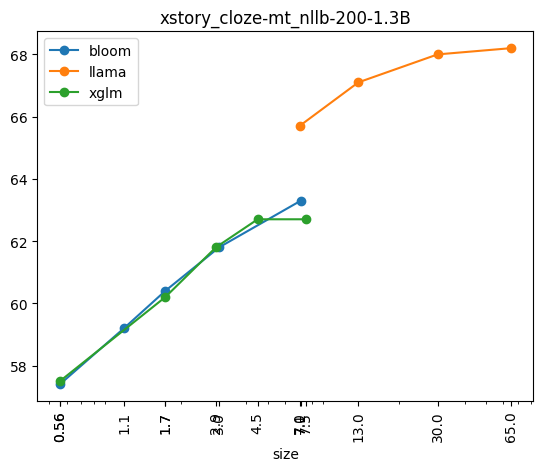

,ar,es,eu,hi,id,my,ru,sw,te,zh,avg,dataset,model,size
xglm-564M,58.1,57.2,55.7,57.4,57.9,55.2,58.8,56.5,59.5,56.8,57.3,xstory_cloze-mt_nllb-200-3.3B,xglm,0.56
xglm-1.7B,61.9,60.4,58.3,61.7,61.4,57.8,62.7,60.0,61.3,61.6,60.7,xstory_cloze-mt_nllb-200-3.3B,xglm,1.70
xglm-2.9B,63.0,63.2,61.2,63.3,62.9,58.8,64.7,60.0,62.8,63.0,62.3,xstory_cloze-mt_nllb-200-3.3B,xglm,2.90
xglm-4.5B,63.9,64.1,60.8,65.0,63.6,60.0,65.3,60.8,63.8,64.3,63.2,xstory_cloze-mt_nllb-200-3.3B,xglm,4.50
xglm-7.5B,64.3,64.7,63.1,64.9,63.4,60.3,65.9,61.4,63.3,65.0,63.6,xstory_cloze-mt_nllb-200-3.3B,xglm,7.50
bloom-560m,59.6,57.7,55.6,58.6,56.7,55.9,58.3,56.7,58.4,57.8,57.5,xstory_cloze-mt_nllb-200-3.3B,bloom,0.56
bloom-1b1,58.8,59.6,57.8,59.7,59.4,55.9,61.4,57.8,60.2,59.5,59.0,xstory_cloze-mt_nllb-200-3.3B,bloom,1.10
bloom-1b7,59.6,60.6,59.2,61.6,60.8,58.0,62.7,58.9,61.5,60.8,60.4,xstory_cloze-mt_nllb-200-3.3B,bloom,1.70
bloom-3b,62.0,63.7,60.2,64.1,63.4,59.4,64.8,60.3,63.2,62.1,62.3,xstory_cloze-mt_nllb-200-3.3B,bloom,3.00
bloom-7b1,64.7,65.1,62.9,65.5,64.1,59.8,65.5,62.5,63.9,64.5,63.9,xstory_cloze-mt_nllb-200-3.3B,bloom,7.10


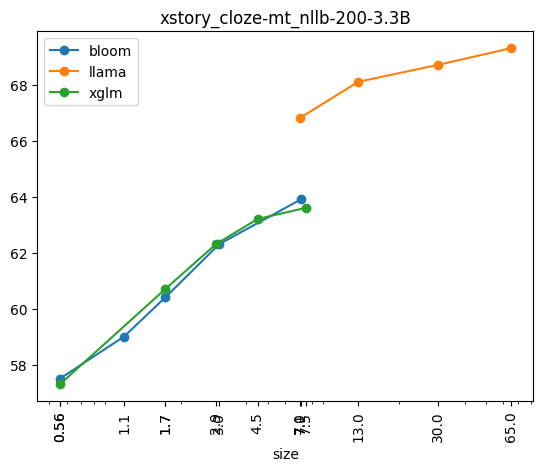

,ar,es,eu,hi,id,my,ru,sw,te,zh,avg,dataset,model,size
xglm-564M,57.6,56.8,57.8,56.5,56.3,53.7,58.4,56.5,58.8,55.7,56.8,xstory_cloze-mt_nllb-200-distilled-600M,xglm,0.56
xglm-1.7B,60.2,59.7,59.4,59.0,59.6,54.9,61.0,58.4,60.9,57.5,59.1,xstory_cloze-mt_nllb-200-distilled-600M,xglm,1.70
xglm-2.9B,60.0,61.6,61.7,61.4,59.7,55.3,62.7,59.6,62.3,58.8,60.3,xstory_cloze-mt_nllb-200-distilled-600M,xglm,2.90
xglm-4.5B,62.1,63.3,61.3,61.2,60.3,56.2,62.9,59.9,62.7,58.3,60.8,xstory_cloze-mt_nllb-200-distilled-600M,xglm,4.50
xglm-7.5B,61.9,63.7,62.0,61.2,60.2,55.8,63.6,60.4,62.9,59.1,61.1,xstory_cloze-mt_nllb-200-distilled-600M,xglm,7.50
bloom-560m,58.2,57.2,57.0,57.0,56.4,53.6,57.6,56.3,58.8,56.3,56.8,xstory_cloze-mt_nllb-200-distilled-600M,bloom,0.56
bloom-1b1,58.8,58.8,58.0,58.3,57.1,54.6,59.3,56.8,59.6,57.1,57.8,xstory_cloze-mt_nllb-200-distilled-600M,bloom,1.10
bloom-1b7,60.0,59.8,59.8,59.6,59.4,55.1,62.1,58.5,61.0,57.5,59.3,xstory_cloze-mt_nllb-200-distilled-600M,bloom,1.70
bloom-3b,60.8,61.9,60.9,61.3,60.8,56.4,62.7,58.6,62.3,58.8,60.4,xstory_cloze-mt_nllb-200-distilled-600M,bloom,3.00
bloom-7b1,62.9,63.3,62.3,61.6,62.0,56.0,63.3,60.8,63.1,59.0,61.4,xstory_cloze-mt_nllb-200-distilled-600M,bloom,7.10


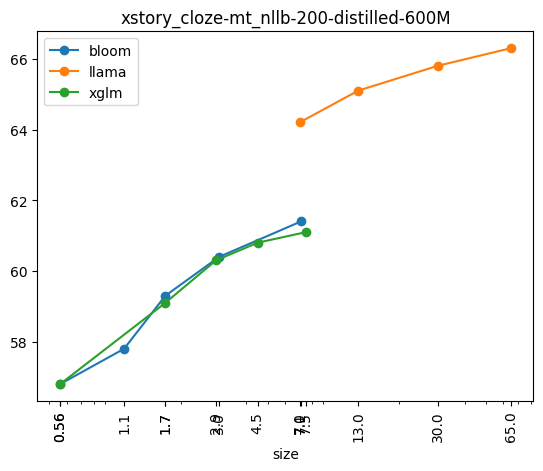

,ar,es,eu,hi,id,my,ru,sw,te,zh,avg,dataset,model,size
xglm-564M,58.7,57.0,58.6,57.8,56.5,55.4,58.8,56.8,59.3,55.6,57.5,xstory_cloze-mt_nllb-200-distilled-1.3B,xglm,0.56
xglm-1.7B,61.3,61.0,59.6,61.2,61.2,56.9,61.5,58.6,60.4,60.3,60.2,xstory_cloze-mt_nllb-200-distilled-1.3B,xglm,1.70
xglm-2.9B,62.1,63.7,62.5,62.5,61.7,58.4,63.1,60.3,61.7,61.0,61.7,xstory_cloze-mt_nllb-200-distilled-1.3B,xglm,2.90
xglm-4.5B,63.3,64.1,62.4,63.5,62.0,59.0,64.6,61.4,62.6,62.1,62.5,xstory_cloze-mt_nllb-200-distilled-1.3B,xglm,4.50
xglm-7.5B,64.2,65.2,63.1,63.1,63.0,59.0,65.1,61.4,61.9,62.2,62.8,xstory_cloze-mt_nllb-200-distilled-1.3B,xglm,7.50
bloom-560m,59.3,57.8,56.7,57.7,57.2,55.8,57.0,56.4,59.2,57.4,57.5,xstory_cloze-mt_nllb-200-distilled-1.3B,bloom,0.56
bloom-1b1,58.6,59.4,58.9,59.2,57.9,56.1,59.4,56.7,59.2,58.6,58.4,xstory_cloze-mt_nllb-200-distilled-1.3B,bloom,1.10
bloom-1b7,61.0,62.0,61.2,60.6,60.0,58.2,61.7,59.0,61.3,58.8,60.4,xstory_cloze-mt_nllb-200-distilled-1.3B,bloom,1.70
bloom-3b,61.6,63.5,62.5,62.2,61.4,57.8,63.1,59.8,62.3,60.9,61.5,xstory_cloze-mt_nllb-200-distilled-1.3B,bloom,3.00
bloom-7b1,63.9,65.0,62.3,63.9,62.7,59.2,64.4,61.0,63.8,62.1,62.8,xstory_cloze-mt_nllb-200-distilled-1.3B,bloom,7.10


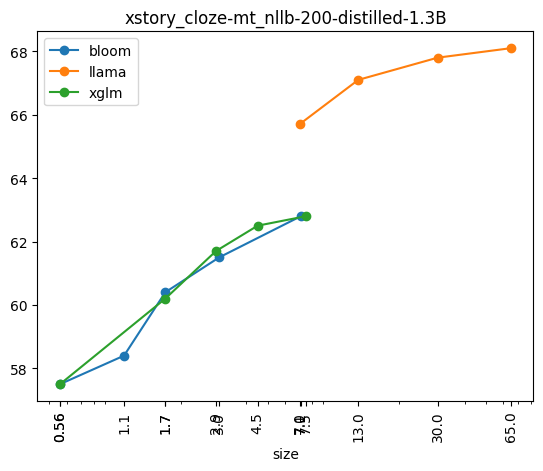

,et,ht,id,it,qu,sw,ta,th,tr,vi,zh,avg,dataset,model,size
xglm-564M,59.6,57.2,57.4,59.8,53.2,55.8,57.2,56.8,61.4,59.8,60.4,58.1,xcopa-mt_nllb-200-distilled-600M,xglm,0.56
xglm-1.7B,62.6,58.8,60.2,62.6,54.4,59.0,58.8,57.8,61.8,62.0,64.4,60.2,xcopa-mt_nllb-200-distilled-600M,xglm,1.70
xglm-2.9B,65.2,61.4,64.0,66.0,55.0,60.4,61.0,61.2,65.0,65.4,66.2,62.8,xcopa-mt_nllb-200-distilled-600M,xglm,2.90
xglm-4.5B,65.2,61.4,65.6,66.2,55.2,59.6,62.2,62.2,64.6,65.8,65.6,63.1,xcopa-mt_nllb-200-distilled-600M,xglm,4.50
xglm-7.5B,65.8,62.2,66.6,65.8,54.6,60.8,62.4,61.0,66.8,65.6,66.2,63.4,xcopa-mt_nllb-200-distilled-600M,xglm,7.50
bloom-560m,62.6,58.2,57.2,61.2,53.8,56.0,57.6,56.8,61.2,59.0,63.4,58.8,xcopa-mt_nllb-200-distilled-600M,bloom,0.56
bloom-1b1,63.0,60.2,59.6,64.8,54.0,59.0,59.8,59.4,63.6,62.4,64.8,61.0,xcopa-mt_nllb-200-distilled-600M,bloom,1.10
bloom-1b7,62.4,60.2,61.0,66.4,54.0,58.0,59.6,60.0,65.4,63.6,66.0,61.5,xcopa-mt_nllb-200-distilled-600M,bloom,1.70
bloom-3b,65.0,62.2,66.4,67.8,52.2,59.6,61.8,62.0,67.6,66.4,66.4,63.4,xcopa-mt_nllb-200-distilled-600M,bloom,3.00
bloom-7b1,66.8,62.4,66.4,67.6,53.2,61.2,62.4,63.4,67.2,66.4,66.0,63.9,xcopa-mt_nllb-200-distilled-600M,bloom,7.10


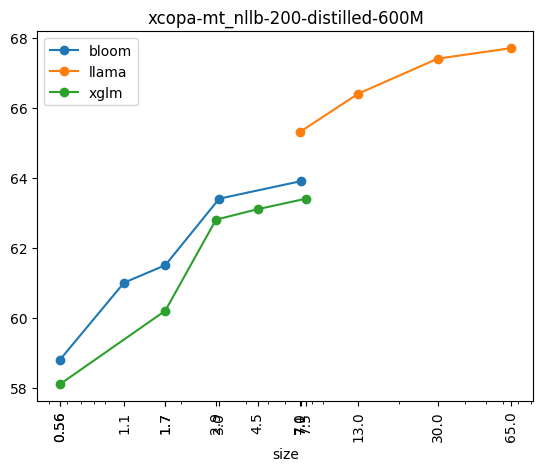

,et,ht,id,it,qu,sw,ta,th,tr,vi,zh,avg,dataset,model,size
xglm-564M,60.0,61.0,60.4,61.8,50.4,59.4,61.6,58.8,62.4,61.8,60.2,59.8,xcopa-mt_nllb-200-3.3B,xglm,0.56
xglm-1.7B,65.6,62.8,63.4,65.6,50.4,62.2,63.8,61.0,63.8,64.0,62.6,62.3,xcopa-mt_nllb-200-3.3B,xglm,1.70
xglm-2.9B,69.2,65.4,67.2,70.8,51.0,64.8,65.2,64.0,66.4,67.2,67.0,65.3,xcopa-mt_nllb-200-3.3B,xglm,2.90
xglm-4.5B,70.0,63.6,68.4,72.2,50.6,65.6,66.0,62.6,66.6,68.8,66.4,65.5,xcopa-mt_nllb-200-3.3B,xglm,4.50
xglm-7.5B,71.8,64.8,67.6,72.8,50.4,66.8,67.4,62.0,69.8,68.6,67.6,66.3,xcopa-mt_nllb-200-3.3B,xglm,7.50
bloom-560m,62.2,62.0,60.8,63.2,50.6,63.6,59.4,58.0,62.0,62.8,63.0,60.7,xcopa-mt_nllb-200-3.3B,bloom,0.56
bloom-1b1,66.6,63.4,63.4,67.2,50.6,64.6,63.6,59.2,65.8,64.8,64.4,63.1,xcopa-mt_nllb-200-3.3B,bloom,1.10
bloom-1b7,66.8,63.0,64.4,68.0,51.6,64.0,64.8,61.0,66.4,64.4,66.2,63.7,xcopa-mt_nllb-200-3.3B,bloom,1.70
bloom-3b,70.4,65.4,67.6,71.4,51.6,66.0,66.0,61.6,67.8,67.4,66.6,65.6,xcopa-mt_nllb-200-3.3B,bloom,3.00
bloom-7b1,71.2,65.6,69.8,71.4,52.0,66.4,68.0,63.8,68.8,70.4,70.6,67.1,xcopa-mt_nllb-200-3.3B,bloom,7.10


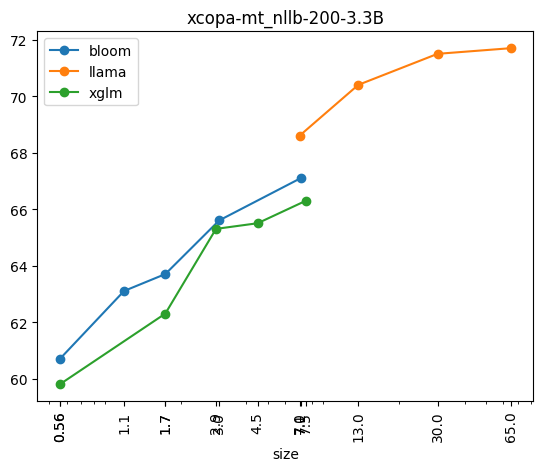

,et,ht,id,it,qu,sw,ta,th,tr,vi,zh,avg,dataset,model,size
xglm-564M,60.6,58.0,59.4,60.0,48.6,60.0,58.4,56.0,61.4,62.4,60.6,58.7,xcopa-mt_nllb-200-1.3B,xglm,0.56
xglm-1.7B,64.6,61.4,63.6,64.4,49.6,61.2,62.2,56.0,65.6,64.4,64.4,61.6,xcopa-mt_nllb-200-1.3B,xglm,1.70
xglm-2.9B,65.6,63.8,68.0,67.6,49.8,64.8,64.0,58.2,67.6,68.2,65.4,63.9,xcopa-mt_nllb-200-1.3B,xglm,2.90
xglm-4.5B,67.2,65.0,67.6,69.0,48.2,64.6,64.4,60.0,67.6,68.4,66.2,64.4,xcopa-mt_nllb-200-1.3B,xglm,4.50
xglm-7.5B,68.2,64.8,68.2,70.6,49.2,66.0,64.8,59.2,70.2,67.8,68.6,65.2,xcopa-mt_nllb-200-1.3B,xglm,7.50
bloom-560m,61.6,60.8,59.8,62.0,48.0,60.8,60.2,56.0,63.2,62.6,62.6,59.8,xcopa-mt_nllb-200-1.3B,bloom,0.56
bloom-1b1,65.4,63.0,63.2,65.6,47.4,61.4,62.2,58.2,64.2,65.8,64.6,61.9,xcopa-mt_nllb-200-1.3B,bloom,1.10
bloom-1b7,64.6,63.2,64.4,65.6,47.6,62.0,62.2,59.4,69.2,66.2,67.8,62.9,xcopa-mt_nllb-200-1.3B,bloom,1.70
bloom-3b,66.6,65.6,69.4,66.4,48.6,63.8,63.4,60.4,70.4,67.2,66.8,64.4,xcopa-mt_nllb-200-1.3B,bloom,3.00
bloom-7b1,70.4,67.6,69.4,69.4,49.6,65.4,65.4,60.8,71.0,70.8,68.2,66.2,xcopa-mt_nllb-200-1.3B,bloom,7.10


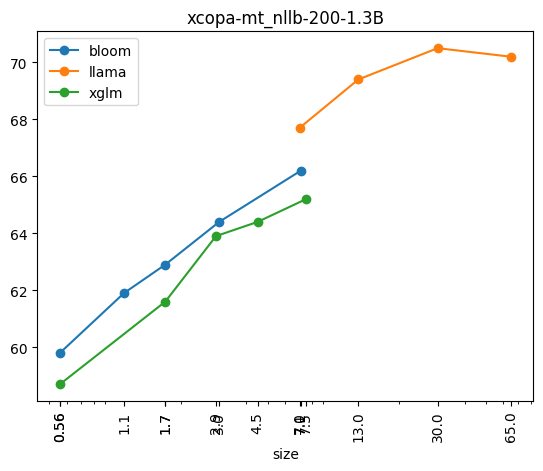

,et,ht,id,it,qu,sw,ta,th,tr,vi,zh,avg,dataset,model,size
xglm-564M,59.2,60.6,59.0,62.4,54.8,61.0,57.8,60.0,62.0,62.2,62.2,60.1,xcopa-mt_nllb-200-distilled-1.3B,xglm,0.56
xglm-1.7B,65.2,62.0,60.2,63.8,54.4,59.2,61.2,61.8,63.4,65.8,66.8,62.2,xcopa-mt_nllb-200-distilled-1.3B,xglm,1.70
xglm-2.9B,67.2,64.8,64.8,69.6,55.6,64.2,64.0,64.4,65.2,66.4,68.8,65.0,xcopa-mt_nllb-200-distilled-1.3B,xglm,2.90
xglm-4.5B,66.6,63.6,66.2,70.0,55.4,63.2,65.6,65.0,64.8,67.8,68.8,65.2,xcopa-mt_nllb-200-distilled-1.3B,xglm,4.50
xglm-7.5B,70.0,65.4,66.0,71.0,56.8,63.6,65.2,65.2,66.6,67.6,69.2,66.1,xcopa-mt_nllb-200-distilled-1.3B,xglm,7.50
bloom-560m,61.0,62.2,59.4,62.2,54.0,61.2,58.8,60.6,60.0,60.8,66.4,60.6,xcopa-mt_nllb-200-distilled-1.3B,bloom,0.56
bloom-1b1,64.2,62.6,62.6,66.8,55.2,62.2,62.2,62.2,63.2,65.6,66.6,63.0,xcopa-mt_nllb-200-distilled-1.3B,bloom,1.10
bloom-1b7,66.2,63.8,63.2,66.6,57.0,62.0,62.2,63.0,63.2,66.6,68.4,63.8,xcopa-mt_nllb-200-distilled-1.3B,bloom,1.70
bloom-3b,68.0,65.6,65.2,69.0,56.8,63.6,64.4,64.6,66.6,68.0,69.6,65.6,xcopa-mt_nllb-200-distilled-1.3B,bloom,3.00
bloom-7b1,71.0,67.2,66.8,71.2,57.6,65.8,65.8,62.8,69.2,68.4,71.4,67.0,xcopa-mt_nllb-200-distilled-1.3B,bloom,7.10


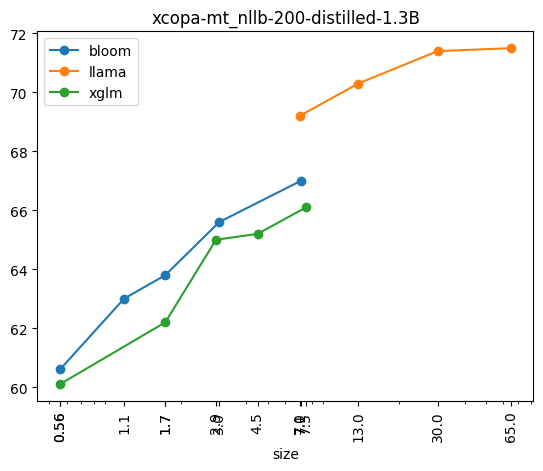

,ar,bg,de,el,es,fr,hi,ru,sw,th,tr,ur,vi,zh,avg,dataset,model,size
xglm-564M,46.9,47.1,46.6,46.6,47.5,46.5,45.6,45.7,45.6,46.3,46.4,43.8,46.8,47.1,46.3,xnli-mt_nllb-200-3.3B,xglm,0.56
xglm-1.7B,47.3,47.8,48.8,48.1,48.5,48.6,47.1,47.2,45.9,46.5,48.3,44.2,48.6,47.3,47.4,xnli-mt_nllb-200-3.3B,xglm,1.70
xglm-2.9B,48.9,49.5,50.0,49.4,50.5,50.0,48.5,47.9,47.7,47.5,48.6,45.4,49.6,49.0,48.8,xnli-mt_nllb-200-3.3B,xglm,2.90
xglm-4.5B,50.3,51.8,52.1,51.0,52.9,52.0,49.5,49.9,47.1,48.2,50.5,46.7,49.9,49.1,50.1,xnli-mt_nllb-200-3.3B,xglm,4.50
xglm-7.5B,50.6,51.8,51.8,51.6,52.8,52.1,51.0,50.5,48.7,48.6,51.8,46.9,50.2,51.2,50.7,xnli-mt_nllb-200-3.3B,xglm,7.50
bloom-560m,46.9,47.6,48.4,48.6,48.5,48.6,47.0,47.6,46.5,46.3,48.2,45.5,48.0,47.7,47.5,xnli-mt_nllb-200-3.3B,bloom,0.56
bloom-1b1,48.9,49.1,49.9,49.7,50.4,50.4,48.8,49.0,47.8,47.4,49.9,47.1,49.8,48.8,49.1,xnli-mt_nllb-200-3.3B,bloom,1.10
bloom-1b7,48.0,48.8,49.5,48.6,49.3,49.9,48.1,47.9,46.6,47.4,48.9,45.3,48.1,48.1,48.2,xnli-mt_nllb-200-3.3B,bloom,1.70
bloom-3b,51.3,51.8,51.1,51.4,52.7,52.4,50.6,50.5,49.2,49.2,50.5,47.4,51.2,51.1,50.7,xnli-mt_nllb-200-3.3B,bloom,3.00
bloom-7b1,51.2,52.3,52.3,51.8,53.1,52.4,50.9,51.0,49.3,49.1,51.5,47.1,51.7,50.9,51.0,xnli-mt_nllb-200-3.3B,bloom,7.10


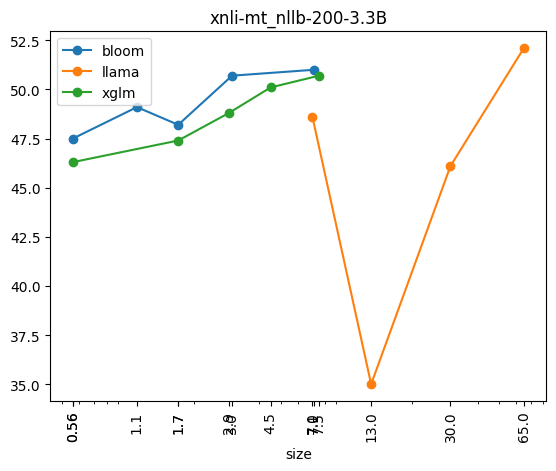

,ar,bg,de,el,es,fr,hi,ru,sw,th,tr,ur,vi,zh,avg,dataset,model,size
xglm-564M,47.1,46.6,46.6,46.9,48.2,46.7,45.6,46.6,44.9,45.8,46.4,44.3,45.9,46.2,46.3,xnli-mt_nllb-200-distilled-600M,xglm,0.56
xglm-1.7B,47.0,48.2,48.4,47.8,48.2,48.2,46.4,47.1,45.9,45.8,47.2,45.2,47.4,46.6,47.1,xnli-mt_nllb-200-distilled-600M,xglm,1.70
xglm-2.9B,48.7,49.5,49.3,49.3,50.1,49.5,48.0,47.8,46.8,46.4,48.4,45.7,48.6,48.2,48.3,xnli-mt_nllb-200-distilled-600M,xglm,2.90
xglm-4.5B,49.3,51.4,51.0,50.5,51.7,51.4,49.0,49.5,47.1,48.8,50.2,45.9,49.9,49.2,49.6,xnli-mt_nllb-200-distilled-600M,xglm,4.50
xglm-7.5B,50.4,51.9,52.1,51.3,52.5,51.6,49.0,50.6,49.1,48.0,50.6,46.6,50.5,50.5,50.3,xnli-mt_nllb-200-distilled-600M,xglm,7.50
bloom-560m,47.6,47.8,48.1,47.9,47.8,47.8,47.1,46.7,46.0,47.2,47.9,45.0,47.3,47.4,47.3,xnli-mt_nllb-200-distilled-600M,bloom,0.56
bloom-1b1,48.1,49.0,49.5,50.1,50.2,50.6,48.7,48.3,46.8,47.7,49.5,46.6,49.1,48.1,48.7,xnli-mt_nllb-200-distilled-600M,bloom,1.10
bloom-1b7,47.8,48.7,49.4,48.9,49.8,49.3,47.0,47.7,46.6,47.3,48.2,45.6,49.3,47.2,48.1,xnli-mt_nllb-200-distilled-600M,bloom,1.70
bloom-3b,50.5,51.6,51.2,50.9,52.5,50.6,49.5,50.0,49.0,49.2,50.4,48.2,50.8,49.8,50.3,xnli-mt_nllb-200-distilled-600M,bloom,3.00
bloom-7b1,51.2,51.9,52.0,51.6,52.7,51.7,49.7,50.8,49.0,48.7,50.6,47.0,51.1,49.5,50.5,xnli-mt_nllb-200-distilled-600M,bloom,7.10


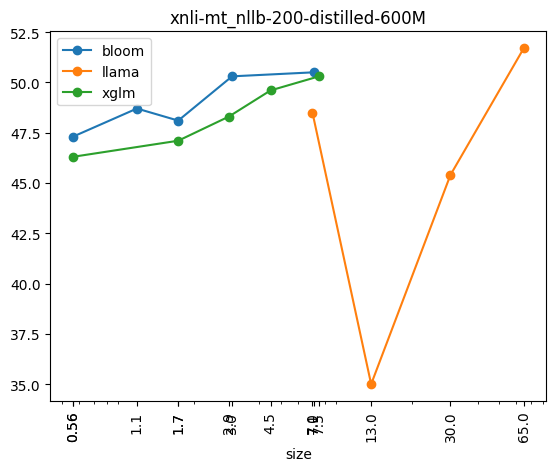

,ar,bg,de,el,es,fr,hi,ru,sw,th,tr,ur,vi,zh,avg,dataset,model,size
xglm-564M,46.1,47.1,46.7,46.9,47.4,46.5,45.6,46.3,46.2,44.9,46.6,45.2,46.7,45.8,46.3,xnli-mt_nllb-200-distilled-1.3B,xglm,0.56
xglm-1.7B,46.8,48.1,48.4,47.7,48.4,48.1,46.1,46.5,46.5,45.9,47.4,45.5,48.3,46.7,47.2,xnli-mt_nllb-200-distilled-1.3B,xglm,1.70
xglm-2.9B,48.6,49.6,49.4,49.4,50.0,49.3,47.8,48.9,47.1,46.6,48.3,45.9,48.9,48.6,48.5,xnli-mt_nllb-200-distilled-1.3B,xglm,2.90
xglm-4.5B,49.7,51.5,51.7,51.0,52.2,52.2,49.2,50.0,48.5,47.9,49.5,47.0,50.3,49.0,50.0,xnli-mt_nllb-200-distilled-1.3B,xglm,4.50
xglm-7.5B,49.8,52.2,51.9,51.8,52.9,51.6,49.5,50.4,48.8,48.7,51.0,47.0,50.1,50.3,50.4,xnli-mt_nllb-200-distilled-1.3B,xglm,7.50
bloom-560m,47.3,48.1,48.9,48.2,48.7,48.0,47.0,47.2,47.0,46.5,47.9,45.4,48.1,47.1,47.5,xnli-mt_nllb-200-distilled-1.3B,bloom,0.56
bloom-1b1,48.6,49.3,49.5,50.0,50.8,50.0,48.2,48.7,47.0,47.9,49.6,46.9,49.2,48.7,48.9,xnli-mt_nllb-200-distilled-1.3B,bloom,1.10
bloom-1b7,47.4,49.2,48.8,48.8,49.3,49.2,47.5,48.3,47.3,46.1,47.8,46.0,48.5,48.1,48.0,xnli-mt_nllb-200-distilled-1.3B,bloom,1.70
bloom-3b,50.8,51.2,51.9,51.9,52.4,51.3,50.3,50.2,49.8,48.4,50.6,47.5,51.3,51.1,50.6,xnli-mt_nllb-200-distilled-1.3B,bloom,3.00
bloom-7b1,51.0,52.1,51.6,52.3,52.7,52.0,51.2,51.5,49.7,48.9,50.7,47.8,50.4,50.0,50.9,xnli-mt_nllb-200-distilled-1.3B,bloom,7.10


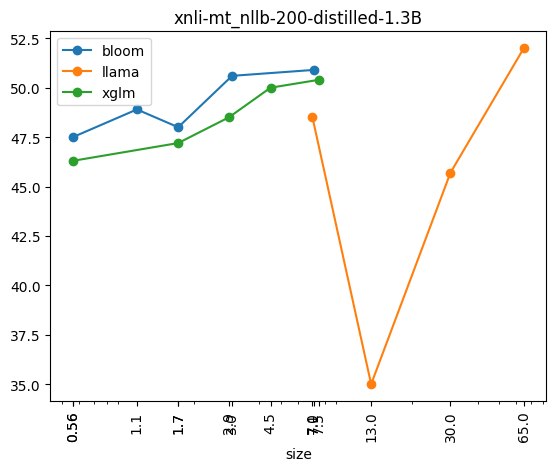

,ar,bg,de,el,es,fr,hi,ru,sw,th,tr,ur,vi,zh,avg,dataset,model,size
xglm-564M,46.1,47.0,46.6,46.6,48.1,46.2,45.6,46.8,46.2,45.5,46.1,43.9,46.1,46.3,46.2,xnli-mt_nllb-200-1.3B,xglm,0.56
xglm-1.7B,46.5,48.0,48.2,47.6,48.5,47.7,47.0,47.5,46.5,46.8,47.6,44.9,47.7,46.7,47.2,xnli-mt_nllb-200-1.3B,xglm,1.70
xglm-2.9B,48.8,49.5,50.2,48.6,50.0,50.1,48.0,48.8,47.3,47.3,48.5,45.8,49.2,48.8,48.6,xnli-mt_nllb-200-1.3B,xglm,2.90
xglm-4.5B,50.3,52.0,51.4,50.3,52.1,51.4,48.7,50.4,48.2,48.2,49.9,46.2,50.0,49.2,49.9,xnli-mt_nllb-200-1.3B,xglm,4.50
xglm-7.5B,50.0,53.1,52.1,51.5,52.1,52.1,49.7,51.1,49.0,48.2,51.0,47.0,50.2,50.0,50.5,xnli-mt_nllb-200-1.3B,xglm,7.50
bloom-560m,47.7,48.0,49.0,48.5,48.3,48.0,46.6,47.5,46.7,46.8,48.6,45.2,47.7,46.9,47.5,xnli-mt_nllb-200-1.3B,bloom,0.56
bloom-1b1,49.3,48.9,49.8,49.8,50.1,49.9,48.5,48.7,48.1,47.6,49.8,45.9,49.1,48.6,48.9,xnli-mt_nllb-200-1.3B,bloom,1.10
bloom-1b7,48.0,48.8,50.0,48.9,49.7,49.2,47.6,47.8,47.0,47.0,48.9,45.2,48.3,48.3,48.2,xnli-mt_nllb-200-1.3B,bloom,1.70
bloom-3b,50.8,51.7,51.7,51.3,53.0,52.0,50.5,50.8,49.5,49.9,51.3,47.8,51.3,50.0,50.8,xnli-mt_nllb-200-1.3B,bloom,3.00
bloom-7b1,50.2,52.3,51.8,51.8,52.4,52.1,50.3,51.1,49.1,48.2,50.8,47.5,51.1,49.8,50.6,xnli-mt_nllb-200-1.3B,bloom,7.10


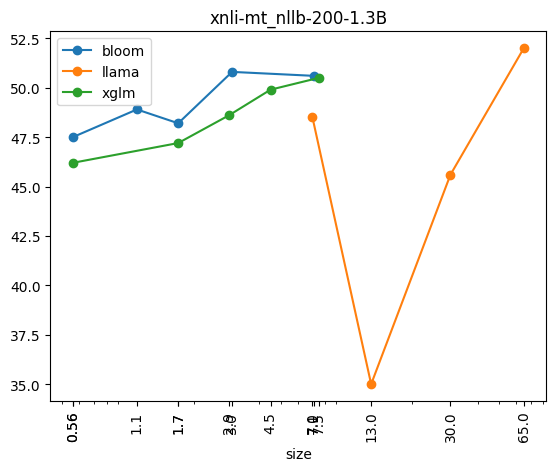

,de,es,fr,ja,ko,zh,avg,dataset,model,size
xglm-564M,52.0,52.6,50.9,49.5,49.6,51.2,51.0,pawsx-mt_nllb-200-distilled-600M,xglm,0.56
xglm-1.7B,50.5,51.0,52.1,49.1,50.0,50.3,50.5,pawsx-mt_nllb-200-distilled-600M,xglm,1.70
xglm-2.9B,54.9,56.9,55.3,53.0,53.2,53.3,54.4,pawsx-mt_nllb-200-distilled-600M,xglm,2.90
xglm-4.5B,55.1,55.9,54.2,53.6,52.2,54.9,54.3,pawsx-mt_nllb-200-distilled-600M,xglm,4.50
xglm-7.5B,57.7,58.0,58.5,54.6,54.8,55.9,56.6,pawsx-mt_nllb-200-distilled-600M,xglm,7.50
bloom-560m,50.4,50.4,51.0,49.9,50.0,50.0,50.3,pawsx-mt_nllb-200-distilled-600M,bloom,0.56
bloom-1b1,52.8,52.8,55.1,48.8,50.9,52.0,52.1,pawsx-mt_nllb-200-distilled-600M,bloom,1.10
bloom-1b7,48.4,49.1,50.5,46.9,48.1,48.4,48.6,pawsx-mt_nllb-200-distilled-600M,bloom,1.70
bloom-3b,55.5,54.8,56.0,52.7,51.2,54.1,54.1,pawsx-mt_nllb-200-distilled-600M,bloom,3.00
bloom-7b1,58.0,59.2,60.2,54.2,55.6,56.4,57.3,pawsx-mt_nllb-200-distilled-600M,bloom,7.10


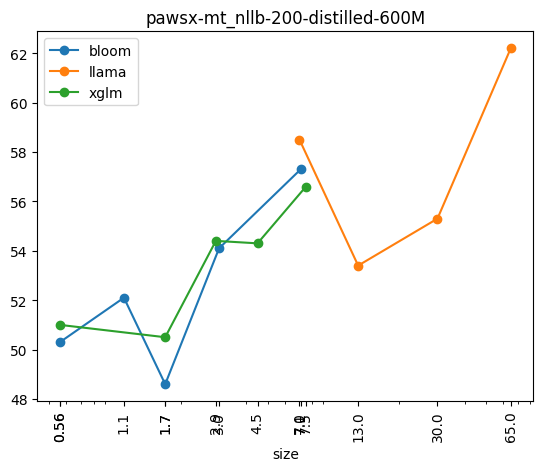

,de,es,fr,ja,ko,zh,avg,dataset,model,size
xglm-564M,53.5,52.8,51.0,51.2,50.4,51.2,51.7,pawsx-mt_nllb-200-3.3B,xglm,0.56
xglm-1.7B,51.9,51.6,52.8,50.2,51.1,49.5,51.2,pawsx-mt_nllb-200-3.3B,xglm,1.70
xglm-2.9B,56.5,57.0,56.2,54.8,54.5,55.4,55.7,pawsx-mt_nllb-200-3.3B,xglm,2.90
xglm-4.5B,57.0,57.6,55.7,54.4,54.0,54.5,55.5,pawsx-mt_nllb-200-3.3B,xglm,4.50
xglm-7.5B,59.6,58.4,59.0,54.6,55.2,57.7,57.4,pawsx-mt_nllb-200-3.3B,xglm,7.50
bloom-560m,49.8,50.8,50.8,49.0,49.5,50.2,50.0,pawsx-mt_nllb-200-3.3B,bloom,0.56
bloom-1b1,53.8,54.2,55.1,50.9,51.2,52.4,52.9,pawsx-mt_nllb-200-3.3B,bloom,1.10
bloom-1b7,49.5,49.3,50.9,47.9,48.9,48.2,49.1,pawsx-mt_nllb-200-3.3B,bloom,1.70
bloom-3b,56.3,56.7,56.5,53.3,52.8,53.1,54.8,pawsx-mt_nllb-200-3.3B,bloom,3.00
bloom-7b1,59.4,61.1,60.0,55.2,56.0,57.0,58.1,pawsx-mt_nllb-200-3.3B,bloom,7.10


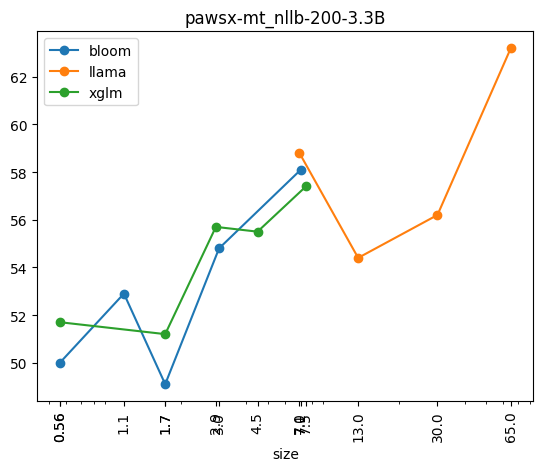

,de,es,fr,ja,ko,zh,avg,dataset,model,size
xglm-564M,52.7,52.3,51.5,51.4,49.4,51.3,51.4,pawsx-mt_nllb-200-1.3B,xglm,0.56
xglm-1.7B,51.7,50.9,51.4,50.4,49.4,49.0,50.5,pawsx-mt_nllb-200-1.3B,xglm,1.70
xglm-2.9B,56.7,57.1,56.0,54.3,52.3,54.9,55.2,pawsx-mt_nllb-200-1.3B,xglm,2.90
xglm-4.5B,56.6,56.5,55.8,53.2,51.3,55.6,54.8,pawsx-mt_nllb-200-1.3B,xglm,4.50
xglm-7.5B,59.0,58.5,58.4,55.4,53.8,57.0,57.0,pawsx-mt_nllb-200-1.3B,xglm,7.50
bloom-560m,50.6,50.1,50.0,49.5,48.9,50.6,49.9,pawsx-mt_nllb-200-1.3B,bloom,0.56
bloom-1b1,53.6,52.5,55.0,50.0,51.4,51.6,52.4,pawsx-mt_nllb-200-1.3B,bloom,1.10
bloom-1b7,49.7,49.6,49.6,47.3,48.0,49.0,48.9,pawsx-mt_nllb-200-1.3B,bloom,1.70
bloom-3b,56.6,55.2,57.0,54.8,51.1,53.4,54.7,pawsx-mt_nllb-200-1.3B,bloom,3.00
bloom-7b1,59.6,59.8,59.9,56.0,54.4,58.2,58.0,pawsx-mt_nllb-200-1.3B,bloom,7.10


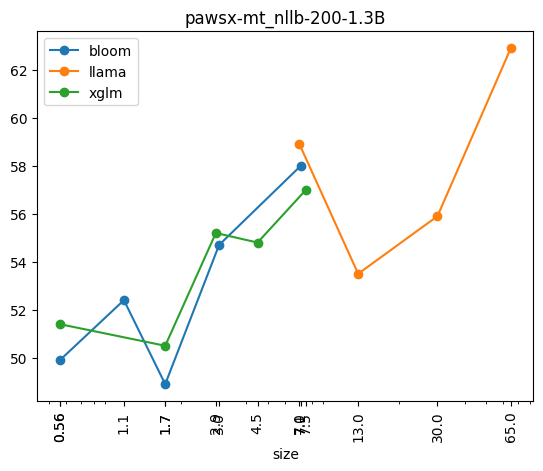

,de,es,fr,ja,ko,zh,avg,dataset,model,size
xglm-564M,53.1,53.1,51.5,51.9,51.1,51.7,52.1,pawsx-mt_nllb-200-distilled-1.3B,xglm,0.56
xglm-1.7B,51.2,52.0,52.3,50.3,49.4,51.0,51.0,pawsx-mt_nllb-200-distilled-1.3B,xglm,1.70
xglm-2.9B,55.5,57.0,56.8,54.4,52.9,55.0,55.3,pawsx-mt_nllb-200-distilled-1.3B,xglm,2.90
xglm-4.5B,57.0,57.9,55.6,52.7,52.9,55.7,55.3,pawsx-mt_nllb-200-distilled-1.3B,xglm,4.50
xglm-7.5B,60.0,58.8,59.3,54.2,54.4,56.5,57.2,pawsx-mt_nllb-200-distilled-1.3B,xglm,7.50
bloom-560m,50.4,51.4,50.4,48.9,49.2,51.8,50.4,pawsx-mt_nllb-200-distilled-1.3B,bloom,0.56
bloom-1b1,52.8,53.7,54.5,51.1,51.1,52.3,52.6,pawsx-mt_nllb-200-distilled-1.3B,bloom,1.10
bloom-1b7,49.8,49.5,49.8,46.9,47.9,48.6,48.8,pawsx-mt_nllb-200-distilled-1.3B,bloom,1.70
bloom-3b,57.0,55.9,56.5,52.8,52.1,53.6,54.7,pawsx-mt_nllb-200-distilled-1.3B,bloom,3.00
bloom-7b1,58.9,61.5,60.8,55.9,54.5,58.4,58.3,pawsx-mt_nllb-200-distilled-1.3B,bloom,7.10


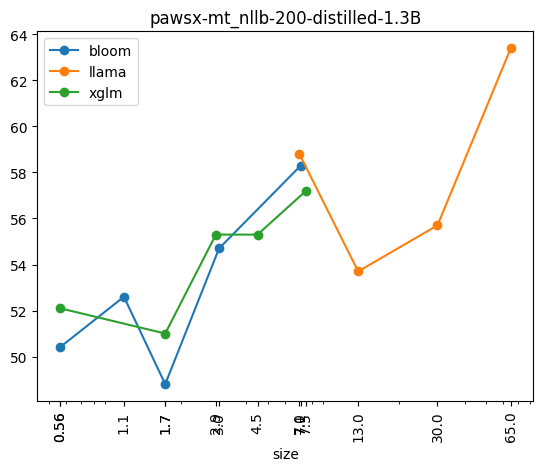

,bn,de,es,fr,ja,ru,sw,te,th,zh,avg,dataset,model,size
xglm-564M,1.2,0.8,0.0,1.2,1.2,1.6,0.8,1.6,1.6,2.4,1.2,mgsm-mt_nllb-200-distilled-600M,xglm,0.56
xglm-1.7B,1.6,1.6,0.8,2.0,2.0,1.2,2.4,1.6,1.6,1.6,1.6,mgsm-mt_nllb-200-distilled-600M,xglm,1.70
xglm-2.9B,2.0,2.8,1.6,2.8,2.4,1.6,2.8,2.8,2.4,4.8,2.6,mgsm-mt_nllb-200-distilled-600M,xglm,2.90
xglm-4.5B,0.0,0.8,0.4,0.4,0.8,0.4,0.4,0.4,1.2,0.8,0.6,mgsm-mt_nllb-200-distilled-600M,xglm,4.50
xglm-7.5B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mgsm-mt_nllb-200-distilled-600M,xglm,7.50
bloom-560m,2.0,3.2,2.4,1.2,2.0,3.2,1.6,1.2,2.8,4.0,2.4,mgsm-mt_nllb-200-distilled-600M,bloom,0.56
bloom-1b1,2.4,0.0,3.2,3.2,2.0,1.6,2.8,1.6,3.2,1.6,2.2,mgsm-mt_nllb-200-distilled-600M,bloom,1.10
bloom-1b7,2.4,2.4,4.0,3.2,2.0,3.2,2.0,2.8,0.8,1.6,2.4,mgsm-mt_nllb-200-distilled-600M,bloom,1.70
bloom-3b,2.4,2.0,0.8,4.0,1.6,3.2,1.2,3.2,2.4,2.4,2.3,mgsm-mt_nllb-200-distilled-600M,bloom,3.00
bloom-7b1,4.8,4.0,3.2,3.2,3.6,3.6,3.2,4.4,5.6,4.8,4.0,mgsm-mt_nllb-200-distilled-600M,bloom,7.10


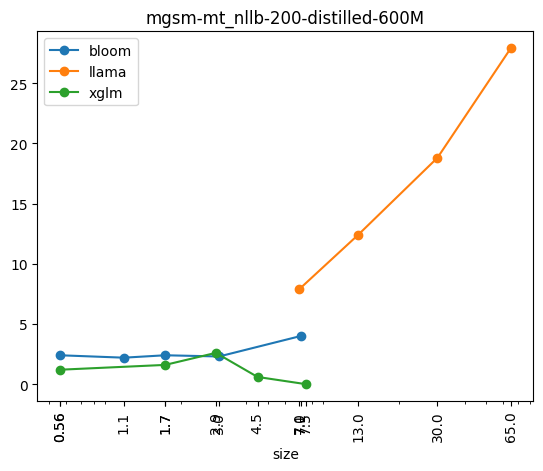

,bn,de,es,fr,ja,ru,sw,te,th,zh,avg,dataset,model,size
xglm-564M,1.2,1.2,0.8,0.4,2.0,1.6,1.2,0.4,2.0,0.0,1.1,mgsm-mt_nllb-200-3.3B,xglm,0.56
xglm-1.7B,2.0,1.2,2.0,1.6,1.6,2.4,2.0,2.8,2.8,2.4,2.1,mgsm-mt_nllb-200-3.3B,xglm,1.70
xglm-2.9B,2.8,2.8,3.2,3.2,1.6,2.0,1.6,2.4,1.2,2.0,2.3,mgsm-mt_nllb-200-3.3B,xglm,2.90
xglm-4.5B,1.2,0.8,0.8,0.4,1.2,0.4,0.4,2.0,1.2,1.6,1.0,mgsm-mt_nllb-200-3.3B,xglm,4.50
xglm-7.5B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,mgsm-mt_nllb-200-3.3B,xglm,7.50
bloom-560m,3.2,2.4,4.4,0.8,1.6,2.0,2.0,1.6,0.8,3.2,2.2,mgsm-mt_nllb-200-3.3B,bloom,0.56
bloom-1b1,1.6,0.8,0.4,2.4,2.0,0.8,1.6,3.2,0.8,2.0,1.6,mgsm-mt_nllb-200-3.3B,bloom,1.10
bloom-1b7,2.8,2.0,2.0,3.6,2.0,2.0,3.6,2.4,3.6,1.6,2.6,mgsm-mt_nllb-200-3.3B,bloom,1.70
bloom-3b,4.4,0.4,2.0,3.2,1.2,1.6,1.6,2.8,2.8,1.2,2.1,mgsm-mt_nllb-200-3.3B,bloom,3.00
bloom-7b1,3.2,2.4,4.8,4.8,3.6,4.8,4.0,6.8,5.2,2.0,4.2,mgsm-mt_nllb-200-3.3B,bloom,7.10


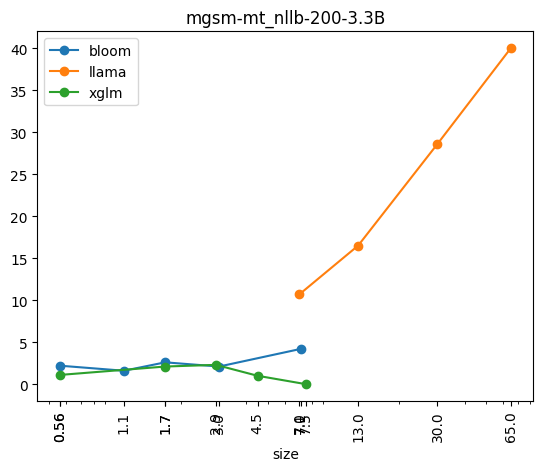

,bn,de,es,fr,ja,ru,sw,te,th,zh,avg,dataset,model,size
xglm-564M,2.0,2.0,0.8,0.8,1.2,1.2,1.6,0.0,2.0,0.8,1.2,mgsm-mt_nllb-200-distilled-1.3B,xglm,0.56
xglm-1.7B,1.6,1.2,2.4,2.0,2.8,2.4,2.8,2.8,2.0,2.4,2.2,mgsm-mt_nllb-200-distilled-1.3B,xglm,1.70
xglm-2.9B,2.8,2.4,2.0,2.8,2.8,2.0,3.2,2.8,3.2,2.8,2.7,mgsm-mt_nllb-200-distilled-1.3B,xglm,2.90
xglm-4.5B,0.8,0.4,0.8,0.0,0.8,1.2,0.0,0.8,1.2,0.4,0.6,mgsm-mt_nllb-200-distilled-1.3B,xglm,4.50
xglm-7.5B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mgsm-mt_nllb-200-distilled-1.3B,xglm,7.50
bloom-560m,3.2,2.4,2.4,1.6,1.6,3.2,2.8,2.4,2.4,3.2,2.5,mgsm-mt_nllb-200-distilled-1.3B,bloom,0.56
bloom-1b1,4.0,0.8,1.6,1.6,2.0,2.0,2.4,3.2,1.6,1.6,2.1,mgsm-mt_nllb-200-distilled-1.3B,bloom,1.10
bloom-1b7,3.2,1.2,2.8,3.6,2.4,2.0,2.8,2.4,2.4,1.2,2.4,mgsm-mt_nllb-200-distilled-1.3B,bloom,1.70
bloom-3b,2.8,2.0,2.4,6.0,1.6,3.6,3.2,3.2,3.2,2.0,3.0,mgsm-mt_nllb-200-distilled-1.3B,bloom,3.00
bloom-7b1,3.6,5.6,3.6,6.0,4.0,3.6,3.2,4.8,2.4,4.4,4.1,mgsm-mt_nllb-200-distilled-1.3B,bloom,7.10


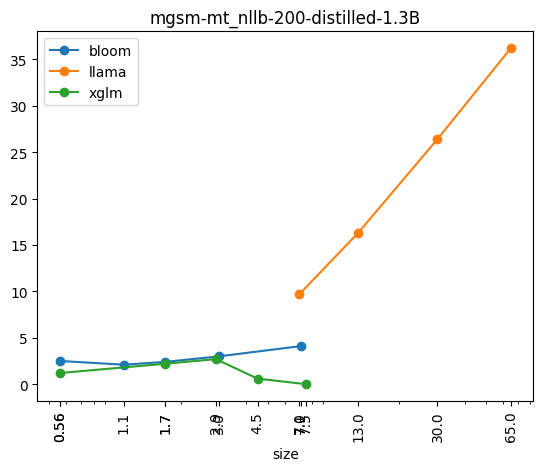

,bn,de,es,fr,ja,ru,sw,te,th,zh,avg,dataset,model,size
xglm-564M,0.4,1.2,0.8,0.8,1.6,1.2,0.8,1.6,0.8,0.8,1.0,mgsm-mt_nllb-200-1.3B,xglm,0.56
xglm-1.7B,2.0,2.4,2.0,2.4,3.2,2.0,2.4,2.4,3.2,2.8,2.5,mgsm-mt_nllb-200-1.3B,xglm,1.70
xglm-2.9B,3.2,1.6,1.6,1.2,1.6,2.4,2.0,1.6,3.2,2.4,2.1,mgsm-mt_nllb-200-1.3B,xglm,2.90
xglm-4.5B,1.2,0.8,0.8,0.0,0.4,1.2,0.8,1.6,0.0,1.2,0.8,mgsm-mt_nllb-200-1.3B,xglm,4.50
xglm-7.5B,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,mgsm-mt_nllb-200-1.3B,xglm,7.50
bloom-560m,3.2,3.6,2.4,2.8,1.2,3.2,2.8,2.0,4.0,4.4,3.0,mgsm-mt_nllb-200-1.3B,bloom,0.56
bloom-1b1,2.8,0.8,1.6,2.8,1.6,1.6,2.0,2.0,2.4,1.6,1.9,mgsm-mt_nllb-200-1.3B,bloom,1.10
bloom-1b7,1.6,2.4,2.0,3.6,2.4,3.6,2.8,2.4,3.6,2.4,2.7,mgsm-mt_nllb-200-1.3B,bloom,1.70
bloom-3b,2.4,2.8,2.8,3.6,2.0,2.4,2.8,3.2,2.8,2.4,2.7,mgsm-mt_nllb-200-1.3B,bloom,3.00
bloom-7b1,4.0,4.8,4.0,4.4,3.6,4.4,4.0,4.8,4.4,4.0,4.2,mgsm-mt_nllb-200-1.3B,bloom,7.10


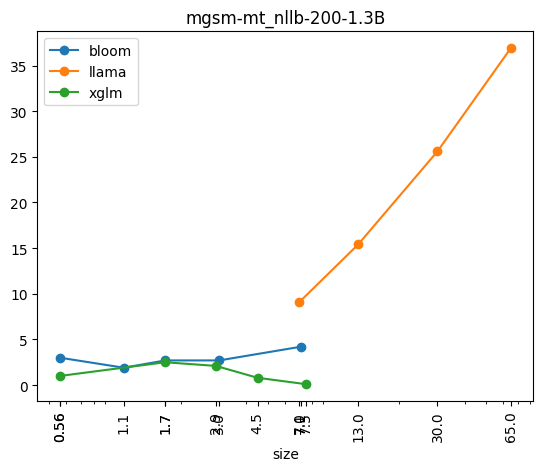

In [20]:
for df in dfs_mt:
    display(df)
    plot_size_df_models(df)

## Results XGLM

In [43]:
def get_dataframes_model(all_results, datasets, model_name):
    dataset_keys = list(all_results.keys())
    for dataset in datasets:
        dfs = []
        for dataset_key in dataset_keys:
            if dataset_key.startswith(dataset):
                results = pd.DataFrame(all_results[dataset_key]).T
                results["dataset"] = dataset_key
                results["model"] = [model.split("-")[0] for model in results.index]
                results = results[results["model"] == model_name]
                results["size"] = model_sizes[model_name]
                dfs.append(results)
        yield pd.concat(dfs)

In [44]:
def plot_size_df_datasets(df, model_name):
    df.set_index("size", inplace=True)
    df.groupby("dataset")["avg"].plot(
        x="size", y="acc", title=list(df["dataset"])[0], legend=True, marker="o"
    )
    # x axis in log scale
    plt.xscale("log")
    plt.xticks(model_sizes[model_name], model_sizes[model_name], rotation="vertical");
    plt.show()

In [45]:
dfs_xglm = get_dataframes_model(all_results, datasets, "xglm")

,ar,en,es,eu,hi,id,my,ru,sw,te,zh,avg,dataset,model,size
xglm-564M,50.1,60.6,55.1,53.1,52.3,54.0,51.5,56.2,53.1,55.9,53.3,54.1,xstory_cloze,xglm,0.56
xglm-1.7B,52.5,64.3,59.2,56.1,55.8,58.0,53.8,59.8,56.0,58.0,56.2,57.2,xstory_cloze,xglm,1.70
xglm-2.9B,53.9,67.3,61.0,56.3,57.5,61.4,55.2,62.2,56.7,60.0,57.6,59.0,xstory_cloze,xglm,2.90
xglm-4.5B,53.7,69.2,62.8,53.7,56.8,60.4,50.8,62.7,55.1,57.0,58.2,58.2,xstory_cloze,xglm,4.50
xglm-7.5B,56.2,69.8,64.1,57.7,58.8,62.9,57.1,63.5,59.3,60.2,58.9,60.8,xstory_cloze,xglm,7.50
xglm-564M,56.9,NaN,57.6,59.6,58.5,56.9,56.1,59.1,56.1,59.8,54.9,57.5,xstory_cloze-mt_nllb-200-1.3B,xglm,0.56
xglm-1.7B,59.6,NaN,61.0,61.6,61.4,60.8,57.4,61.6,59.0,60.8,59.1,60.2,xstory_cloze-mt_nllb-200-1.3B,xglm,1.70
xglm-2.9B,60.9,NaN,63.5,62.3,63.8,61.8,59.4,63.9,61.5,61.8,59.2,61.8,xstory_cloze-mt_nllb-200-1.3B,xglm,2.90
xglm-4.5B,62.6,NaN,64.3,63.6,64.6,61.7,59.2,65.0,61.6,63.2,60.8,62.7,xstory_cloze-mt_nllb-200-1.3B,xglm,4.50
xglm-7.5B,62.4,NaN,64.3,63.4,64.2,62.1,59.2,65.6,61.5,63.0,61.2,62.7,xstory_cloze-mt_nllb-200-1.3B,xglm,7.50


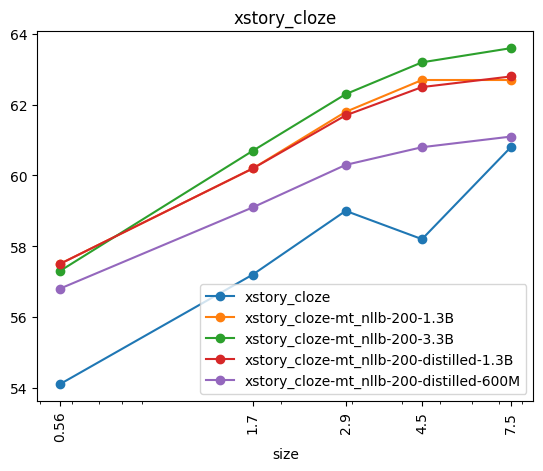

,et,ht,id,it,qu,sw,ta,th,tr,vi,zh,avg,dataset,model,size
xglm-564M,55.6,55.0,57.2,53.8,49.2,53.2,56.2,55.2,54.4,58.4,55.6,54.9,xcopa,xglm,0.56
xglm-1.7B,56.8,55.8,64.6,54.0,52.2,56.6,55.2,58.2,53.4,63.0,58.0,57.1,xcopa,xglm,1.70
xglm-2.9B,58.2,55.8,66.8,60.2,50.2,58.8,54.2,57.0,56.6,65.2,60.0,58.5,xcopa,xglm,2.90
xglm-4.5B,55.0,51.2,67.0,61.6,50.0,56.2,55.6,55.2,57.2,66.0,61.6,57.9,xcopa,xglm,4.50
xglm-7.5B,61.2,57.4,69.4,63.6,48.8,60.0,54.4,59.4,58.4,70.2,63.8,60.6,xcopa,xglm,7.50
xglm-564M,59.6,57.2,57.4,59.8,53.2,55.8,57.2,56.8,61.4,59.8,60.4,58.1,xcopa-mt_nllb-200-distilled-600M,xglm,0.56
xglm-1.7B,62.6,58.8,60.2,62.6,54.4,59.0,58.8,57.8,61.8,62.0,64.4,60.2,xcopa-mt_nllb-200-distilled-600M,xglm,1.70
xglm-2.9B,65.2,61.4,64.0,66.0,55.0,60.4,61.0,61.2,65.0,65.4,66.2,62.8,xcopa-mt_nllb-200-distilled-600M,xglm,2.90
xglm-4.5B,65.2,61.4,65.6,66.2,55.2,59.6,62.2,62.2,64.6,65.8,65.6,63.1,xcopa-mt_nllb-200-distilled-600M,xglm,4.50
xglm-7.5B,65.8,62.2,66.6,65.8,54.6,60.8,62.4,61.0,66.8,65.6,66.2,63.4,xcopa-mt_nllb-200-distilled-600M,xglm,7.50


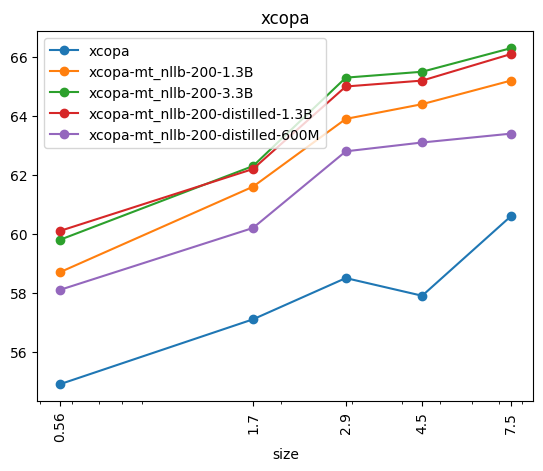

,en,fr,jp,pt,ru,zh,avg,dataset,model,size
xglm-564M,62.6,57.8,54.5,58.6,59.0,65.7,59.7,xwinograd,xglm,0.56
xglm-1.7B,71.1,60.2,60.6,63.9,59.7,69.8,64.2,xwinograd,xglm,1.70
xglm-2.9B,75.6,59.0,64.7,66.2,62.9,71.6,66.7,xwinograd,xglm,2.90
xglm-4.5B,76.3,60.2,62.7,64.6,62.2,70.6,66.1,xwinograd,xglm,4.50
xglm-7.5B,79.5,65.1,65.0,67.3,63.2,72.8,68.8,xwinograd,xglm,7.50


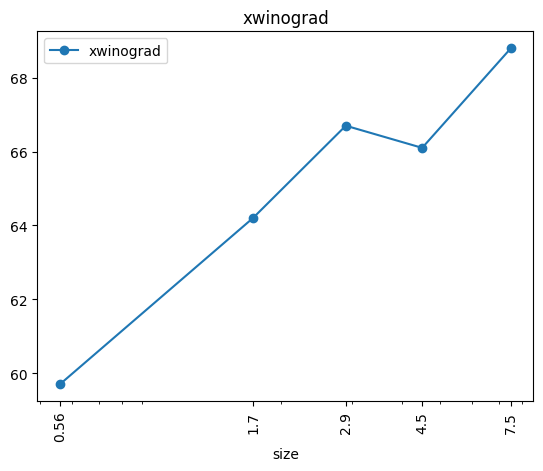

,ar,bg,de,el,en,es,fr,hi,ru,sw,th,tr,ur,vi,zh,avg,dataset,model,size
xglm-564M,33.4,41.3,44.5,39.6,48.3,42.0,45.5,38.7,44.6,36.1,38.8,40.2,34.5,38.5,33.5,40.0,xnli,xglm,0.56
xglm-1.7B,33.5,44.7,45.3,40.1,49.7,43.6,45.7,42.6,46.0,42.0,41.7,43.0,39.5,45.0,33.8,42.4,xnli,xglm,1.70
xglm-2.9B,33.7,46.0,48.3,41.4,51.1,46.7,45.0,44.0,45.3,44.4,42.0,45.0,40.1,46.0,34.8,43.6,xnli,xglm,2.90
xglm-4.5B,33.6,45.6,47.1,39.8,53.6,47.7,47.3,42.5,46.1,39.6,39.7,44.9,37.5,45.9,34.8,43.0,xnli,xglm,4.50
xglm-7.5B,33.4,44.9,49.0,40.7,53.9,47.7,46.9,47.2,46.3,45.8,43.7,46.3,42.1,46.3,35.4,44.6,xnli,xglm,7.50
xglm-564M,46.9,47.1,46.6,46.6,NaN,47.5,46.5,45.6,45.7,45.6,46.3,46.4,43.8,46.8,47.1,46.3,xnli-mt_nllb-200-3.3B,xglm,0.56
xglm-1.7B,47.3,47.8,48.8,48.1,NaN,48.5,48.6,47.1,47.2,45.9,46.5,48.3,44.2,48.6,47.3,47.4,xnli-mt_nllb-200-3.3B,xglm,1.70
xglm-2.9B,48.9,49.5,50.0,49.4,NaN,50.5,50.0,48.5,47.9,47.7,47.5,48.6,45.4,49.6,49.0,48.8,xnli-mt_nllb-200-3.3B,xglm,2.90
xglm-4.5B,50.3,51.8,52.1,51.0,NaN,52.9,52.0,49.5,49.9,47.1,48.2,50.5,46.7,49.9,49.1,50.1,xnli-mt_nllb-200-3.3B,xglm,4.50
xglm-7.5B,50.6,51.8,51.8,51.6,NaN,52.8,52.1,51.0,50.5,48.7,48.6,51.8,46.9,50.2,51.2,50.7,xnli-mt_nllb-200-3.3B,xglm,7.50


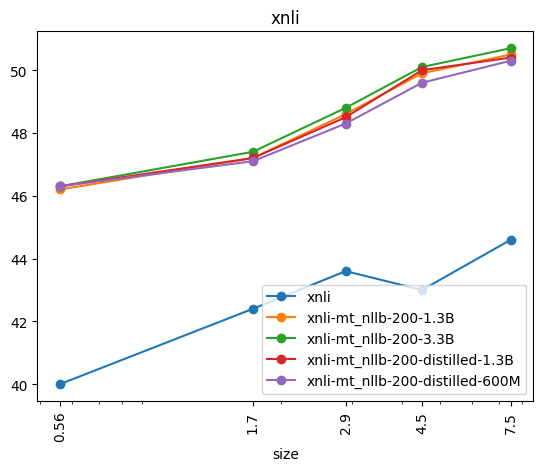

,de,en,es,fr,ja,ko,zh,avg,dataset,model,size
xglm-564M,49.1,50.6,52.5,50.8,44.1,46.2,47.8,48.7,pawsx,xglm,0.56
xglm-1.7B,57.6,52.6,53.8,47.3,46.1,51.4,48.1,51.0,pawsx,xglm,1.70
xglm-2.9B,50.6,54.8,53.1,49.7,50.9,46.8,53.7,51.4,pawsx,xglm,2.90
xglm-4.5B,52.6,55.4,51.0,51.6,47.8,49.1,54.6,51.7,pawsx,xglm,4.50
xglm-7.5B,55.9,58.9,52.8,51.8,52.0,46.0,51.3,52.7,pawsx,xglm,7.50
xglm-564M,52.0,NaN,52.6,50.9,49.5,49.6,51.2,51.0,pawsx-mt_nllb-200-distilled-600M,xglm,0.56
xglm-1.7B,50.5,NaN,51.0,52.1,49.1,50.0,50.3,50.5,pawsx-mt_nllb-200-distilled-600M,xglm,1.70
xglm-2.9B,54.9,NaN,56.9,55.3,53.0,53.2,53.3,54.4,pawsx-mt_nllb-200-distilled-600M,xglm,2.90
xglm-4.5B,55.1,NaN,55.9,54.2,53.6,52.2,54.9,54.3,pawsx-mt_nllb-200-distilled-600M,xglm,4.50
xglm-7.5B,57.7,NaN,58.0,58.5,54.6,54.8,55.9,56.6,pawsx-mt_nllb-200-distilled-600M,xglm,7.50


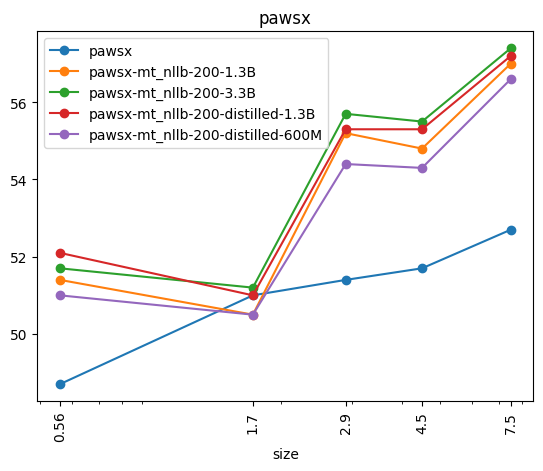

,bn,de,en,es,fr,ja,ru,sw,te,th,zh,avg,dataset,model,size
xglm-564M,1.6,0.8,1.6,1.2,1.6,4.0,0.4,2.4,0.8,1.2,3.6,1.7,mgsm,xglm,0.56
xglm-1.7B,0.8,1.2,0.8,2.8,0.8,2.8,1.2,2.8,1.2,2.4,1.6,1.7,mgsm,xglm,1.70
xglm-2.9B,0.0,1.6,2.4,1.6,0.8,2.0,2.4,2.4,2.4,0.0,1.2,1.5,mgsm,xglm,2.90
xglm-4.5B,0.0,2.0,0.8,1.6,0.4,0.4,2.4,2.8,0.8,0.0,1.6,1.2,mgsm,xglm,4.50
xglm-7.5B,0.0,1.2,0.0,0.0,0.0,0.8,3.2,0.8,1.2,2.4,2.0,1.1,mgsm,xglm,7.50
xglm-564M,1.2,0.8,NaN,0.0,1.2,1.2,1.6,0.8,1.6,1.6,2.4,1.2,mgsm-mt_nllb-200-distilled-600M,xglm,0.56
xglm-1.7B,1.6,1.6,NaN,0.8,2.0,2.0,1.2,2.4,1.6,1.6,1.6,1.6,mgsm-mt_nllb-200-distilled-600M,xglm,1.70
xglm-2.9B,2.0,2.8,NaN,1.6,2.8,2.4,1.6,2.8,2.8,2.4,4.8,2.6,mgsm-mt_nllb-200-distilled-600M,xglm,2.90
xglm-4.5B,0.0,0.8,NaN,0.4,0.4,0.8,0.4,0.4,0.4,1.2,0.8,0.6,mgsm-mt_nllb-200-distilled-600M,xglm,4.50
xglm-7.5B,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mgsm-mt_nllb-200-distilled-600M,xglm,7.50


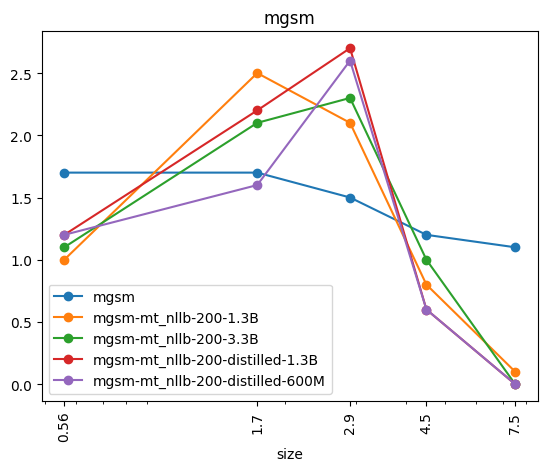

In [46]:
for df in dfs_xglm:
    display(df)
    plot_size_df_datasets(df, "xglm")

## Results BLOOM

,ar,en,es,eu,hi,id,my,ru,sw,te,zh,avg,dataset,model,size
bloom-560m,52.1,61.2,55.9,53.6,55.0,55.5,47.2,49.2,49.8,55.7,54.5,53.6,xstory_cloze,bloom,0.56
bloom-1b1,52.9,62.5,58.3,54.3,55.5,57.9,46.2,48.2,50.6,56.4,58.0,54.6,xstory_cloze,bloom,1.10
bloom-1b7,55.0,64.7,60.8,54.9,56.8,59.8,47.3,50.4,52.3,56.5,58.2,56.1,xstory_cloze,bloom,1.70
bloom-3b,56.6,66.8,64.1,55.7,57.6,60.8,46.6,50.7,53.0,58.2,60.9,57.4,xstory_cloze,bloom,3.00
bloom-7b1,58.6,70.7,66.1,57.2,60.6,64.5,49.0,52.7,53.9,57.4,61.9,59.3,xstory_cloze,bloom,7.10
bloom-560m,58.1,NaN,58.2,58.9,58.3,57.6,55.3,58.0,56.5,58.2,55.3,57.4,xstory_cloze-mt_nllb-200-1.3B,bloom,0.56
bloom-1b1,58.2,NaN,60.5,61.2,59.8,59.5,56.9,60.4,58.1,60.2,56.8,59.2,xstory_cloze-mt_nllb-200-1.3B,bloom,1.10
bloom-1b7,59.2,NaN,61.8,61.9,61.9,58.9,57.4,62.9,59.5,62.3,58.3,60.4,xstory_cloze-mt_nllb-200-1.3B,bloom,1.70
bloom-3b,61.0,NaN,63.6,63.2,62.6,60.2,59.6,63.7,61.2,62.6,60.6,61.8,xstory_cloze-mt_nllb-200-1.3B,bloom,3.00
bloom-7b1,63.2,NaN,64.9,64.6,64.7,62.9,60.8,65.5,61.2,63.8,61.4,63.3,xstory_cloze-mt_nllb-200-1.3B,bloom,7.10


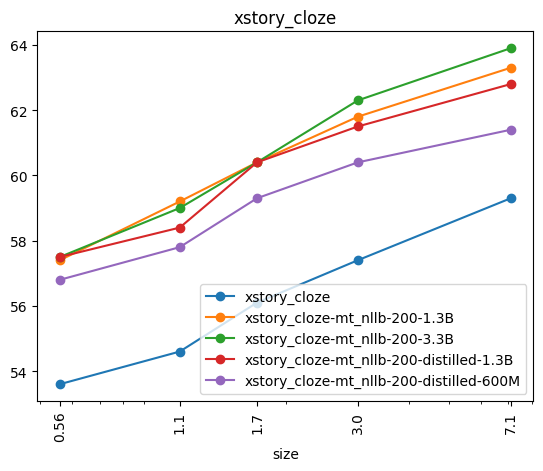

,et,ht,id,it,qu,sw,ta,th,tr,vi,zh,avg,dataset,model,size
bloom-560m,49.0,50.2,59.2,50.8,50.2,51.6,55.8,54.4,53.0,61.0,58.6,54.0,xcopa,bloom,0.56
bloom-1b1,50.6,53.0,64.8,50.8,51.2,54.4,57.0,53.2,53.0,62.4,59.4,55.4,xcopa,bloom,1.10
bloom-1b7,47.4,50.4,63.2,52.6,50.6,51.8,56.6,53.2,52.8,65.8,61.4,55.1,xcopa,bloom,1.70
bloom-3b,49.2,50.2,69.2,51.6,50.6,51.4,58.0,52.6,53.4,68.8,62.0,56.1,xcopa,bloom,3.00
bloom-7b1,48.2,50.8,69.8,52.8,50.8,51.6,59.2,55.4,51.2,70.8,65.2,56.9,xcopa,bloom,7.10
bloom-560m,62.6,58.2,57.2,61.2,53.8,56.0,57.6,56.8,61.2,59.0,63.4,58.8,xcopa-mt_nllb-200-distilled-600M,bloom,0.56
bloom-1b1,63.0,60.2,59.6,64.8,54.0,59.0,59.8,59.4,63.6,62.4,64.8,61.0,xcopa-mt_nllb-200-distilled-600M,bloom,1.10
bloom-1b7,62.4,60.2,61.0,66.4,54.0,58.0,59.6,60.0,65.4,63.6,66.0,61.5,xcopa-mt_nllb-200-distilled-600M,bloom,1.70
bloom-3b,65.0,62.2,66.4,67.8,52.2,59.6,61.8,62.0,67.6,66.4,66.4,63.4,xcopa-mt_nllb-200-distilled-600M,bloom,3.00
bloom-7b1,66.8,62.4,66.4,67.6,53.2,61.2,62.4,63.4,67.2,66.4,66.0,63.9,xcopa-mt_nllb-200-distilled-600M,bloom,7.10


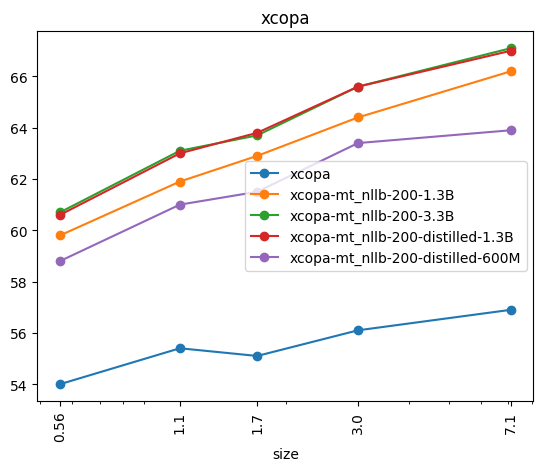

,en,fr,jp,pt,ru,zh,avg,dataset,model,size
bloom-560m,65.9,60.2,53.0,60.1,49.2,67.7,59.4,xwinograd,bloom,0.56
bloom-1b1,70.0,66.3,52.9,63.1,54.3,69.2,62.6,xwinograd,bloom,1.10
bloom-1b7,74.7,68.7,54.1,63.5,52.4,69.6,63.8,xwinograd,bloom,1.70
bloom-3b,79.1,71.1,56.6,70.3,53.7,73.6,67.4,xwinograd,bloom,3.00
bloom-7b1,82.2,71.1,58.5,76.8,56.8,74.4,70.0,xwinograd,bloom,7.10


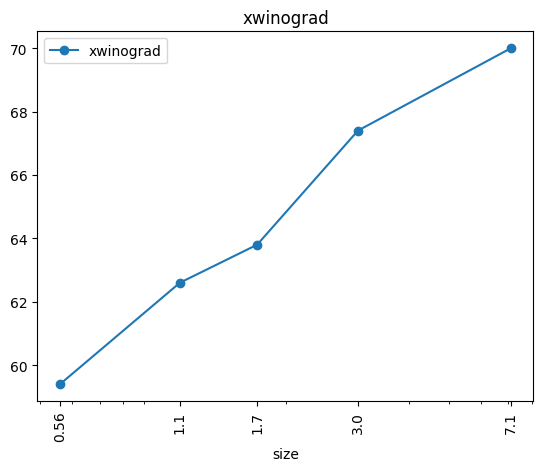

,ar,bg,de,el,en,es,fr,hi,ru,sw,th,tr,ur,vi,zh,avg,dataset,model,size
bloom-560m,33.4,33.4,34.8,33.3,49.5,45.2,45.3,40.8,34.0,33.2,33.6,33.4,37.1,40.5,34.0,37.4,xnli,bloom,0.56
bloom-1b1,33.9,34.1,39.6,34.0,51.5,48.0,47.1,42.3,40.5,35.3,33.8,34.8,37.3,44.5,36.2,39.5,xnli,bloom,1.10
bloom-1b7,33.6,35.4,40.6,34.0,50.1,47.8,48.2,44.0,39.3,34.5,33.4,34.9,40.5,46.2,36.2,39.9,xnli,bloom,1.70
bloom-3b,33.4,37.9,40.4,33.2,53.4,49.1,49.2,45.5,41.4,35.8,33.4,33.8,40.0,46.5,37.4,40.7,xnli,bloom,3.00
bloom-7b1,33.8,39.7,39.9,35.7,53.9,48.7,49.7,46.5,43.1,37.9,35.0,35.1,42.1,47.0,35.4,41.6,xnli,bloom,7.10
bloom-560m,46.9,47.6,48.4,48.6,NaN,48.5,48.6,47.0,47.6,46.5,46.3,48.2,45.5,48.0,47.7,47.5,xnli-mt_nllb-200-3.3B,bloom,0.56
bloom-1b1,48.9,49.1,49.9,49.7,NaN,50.4,50.4,48.8,49.0,47.8,47.4,49.9,47.1,49.8,48.8,49.1,xnli-mt_nllb-200-3.3B,bloom,1.10
bloom-1b7,48.0,48.8,49.5,48.6,NaN,49.3,49.9,48.1,47.9,46.6,47.4,48.9,45.3,48.1,48.1,48.2,xnli-mt_nllb-200-3.3B,bloom,1.70
bloom-3b,51.3,51.8,51.1,51.4,NaN,52.7,52.4,50.6,50.5,49.2,49.2,50.5,47.4,51.2,51.1,50.7,xnli-mt_nllb-200-3.3B,bloom,3.00
bloom-7b1,51.2,52.3,52.3,51.8,NaN,53.1,52.4,50.9,51.0,49.3,49.1,51.5,47.1,51.7,50.9,51.0,xnli-mt_nllb-200-3.3B,bloom,7.10


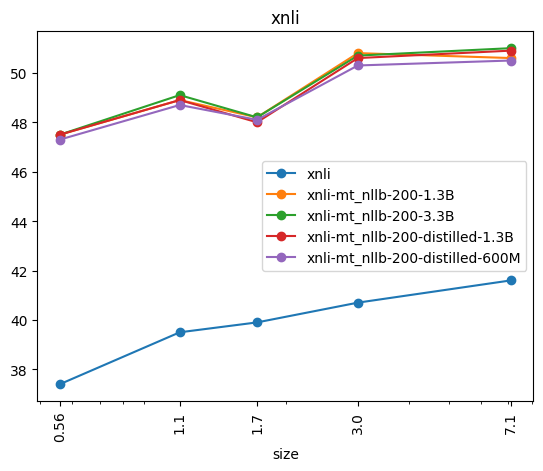

,de,en,es,fr,ja,ko,zh,avg,dataset,model,size
bloom-560m,52.8,52.0,53.2,47.9,44.9,51.9,45.2,49.7,pawsx,bloom,0.56
bloom-1b1,46.9,52.4,51.5,46.2,48.4,49.9,48.9,49.2,pawsx,bloom,1.10
bloom-1b7,48.8,48.9,51.3,46.2,44.7,45.8,45.4,47.3,pawsx,bloom,1.70
bloom-3b,54.6,56.8,56.4,47.6,44.6,46.3,47.1,50.5,pawsx,bloom,3.00
bloom-7b1,52.8,61.3,59.4,50.9,45.5,45.1,47.3,51.8,pawsx,bloom,7.10
bloom-560m,50.4,NaN,50.4,51.0,49.9,50.0,50.0,50.3,pawsx-mt_nllb-200-distilled-600M,bloom,0.56
bloom-1b1,52.8,NaN,52.8,55.1,48.8,50.9,52.0,52.1,pawsx-mt_nllb-200-distilled-600M,bloom,1.10
bloom-1b7,48.4,NaN,49.1,50.5,46.9,48.1,48.4,48.6,pawsx-mt_nllb-200-distilled-600M,bloom,1.70
bloom-3b,55.5,NaN,54.8,56.0,52.7,51.2,54.1,54.1,pawsx-mt_nllb-200-distilled-600M,bloom,3.00
bloom-7b1,58.0,NaN,59.2,60.2,54.2,55.6,56.4,57.3,pawsx-mt_nllb-200-distilled-600M,bloom,7.10


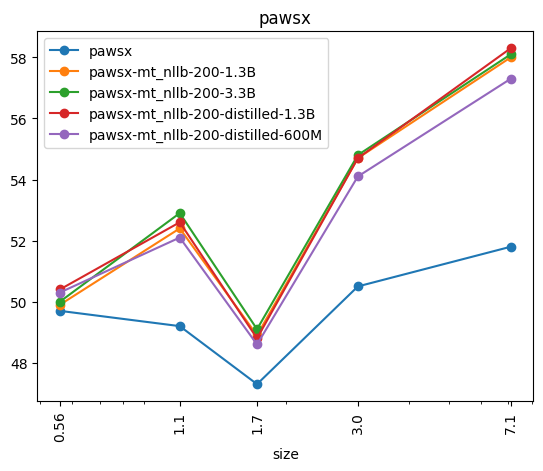

,bn,de,en,es,fr,ja,ru,sw,te,th,zh,avg,dataset,model,size
bloom-560m,3.2,1.2,2.8,2.8,1.6,1.2,2.0,0.8,2.4,0.0,2.0,1.8,mgsm,bloom,0.56
bloom-1b1,2.0,2.0,0.8,2.4,2.4,0.4,2.0,2.8,2.0,0.0,2.8,1.8,mgsm,bloom,1.10
bloom-1b7,2.0,4.0,1.2,2.4,3.2,2.8,2.4,1.6,1.6,0.0,2.8,2.2,mgsm,bloom,1.70
bloom-3b,2.0,1.2,3.2,2.8,2.0,2.4,0.8,2.8,2.4,0.0,3.2,2.1,mgsm,bloom,3.00
bloom-7b1,4.8,0.4,5.2,5.2,4.0,1.2,4.0,2.8,4.4,0.0,4.8,3.3,mgsm,bloom,7.10
bloom-560m,2.0,3.2,NaN,2.4,1.2,2.0,3.2,1.6,1.2,2.8,4.0,2.4,mgsm-mt_nllb-200-distilled-600M,bloom,0.56
bloom-1b1,2.4,0.0,NaN,3.2,3.2,2.0,1.6,2.8,1.6,3.2,1.6,2.2,mgsm-mt_nllb-200-distilled-600M,bloom,1.10
bloom-1b7,2.4,2.4,NaN,4.0,3.2,2.0,3.2,2.0,2.8,0.8,1.6,2.4,mgsm-mt_nllb-200-distilled-600M,bloom,1.70
bloom-3b,2.4,2.0,NaN,0.8,4.0,1.6,3.2,1.2,3.2,2.4,2.4,2.3,mgsm-mt_nllb-200-distilled-600M,bloom,3.00
bloom-7b1,4.8,4.0,NaN,3.2,3.2,3.6,3.6,3.2,4.4,5.6,4.8,4.0,mgsm-mt_nllb-200-distilled-600M,bloom,7.10


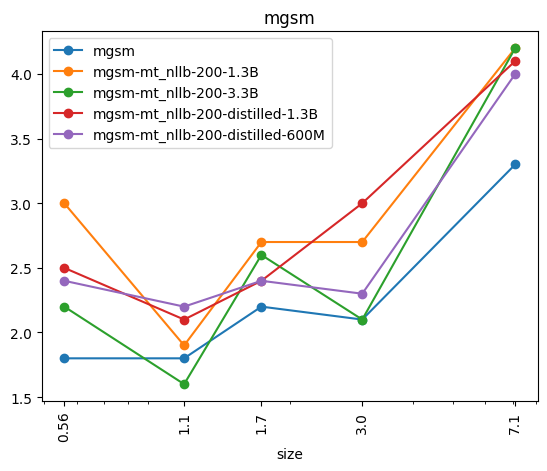

In [47]:
dfs_xglm = get_dataframes_model(all_results, datasets, "bloom")

for df in dfs_xglm:
    display(df)
    plot_size_df_datasets(df, "bloom")

## Results LLaMA

,ar,en,es,eu,hi,id,my,ru,sw,te,zh,avg,dataset,model,size
llama-7B,48.3,74.8,65.1,50.1,52.7,52.1,48.7,61.4,50.4,52.9,54.3,55.5,xstory_cloze,llama,7.0
llama-13B,49.7,77.3,69.4,50.7,52.3,55.3,47.8,63.4,49.9,53.3,56.5,56.9,xstory_cloze,llama,13.0
llama-30B,50.9,78.2,70.8,51.4,56.7,59.2,48.8,66.7,50.6,53.2,58.6,58.6,xstory_cloze,llama,30.0
llama-65B,54.5,78.9,71.4,51.4,58.1,59.7,48.6,68.9,51.6,54.1,60.5,59.8,xstory_cloze,llama,65.0
llama-7B,64.7,NaN,68.5,66.6,67.4,64.6,61.4,69.8,64.6,65.1,64.1,65.7,xstory_cloze-mt_nllb-200-1.3B,llama,7.0
llama-13B,66.4,NaN,70.7,67.9,68.9,66.5,63.1,70.7,65.5,66.6,64.9,67.1,xstory_cloze-mt_nllb-200-1.3B,llama,13.0
llama-30B,67.4,NaN,70.4,68.7,69.9,68.6,63.0,71.3,67.4,67.8,65.7,68.0,xstory_cloze-mt_nllb-200-1.3B,llama,30.0
llama-65B,68.0,NaN,71.6,68.2,70.0,67.7,63.3,72.1,67.4,67.7,65.5,68.2,xstory_cloze-mt_nllb-200-1.3B,llama,65.0
llama-7B,67.7,NaN,68.4,65.4,68.5,68.3,62.5,70.1,64.3,65.5,67.2,66.8,xstory_cloze-mt_nllb-200-3.3B,llama,7.0
llama-13B,68.6,NaN,70.0,66.4,70.0,69.0,62.8,71.7,66.0,67.7,69.1,68.1,xstory_cloze-mt_nllb-200-3.3B,llama,13.0


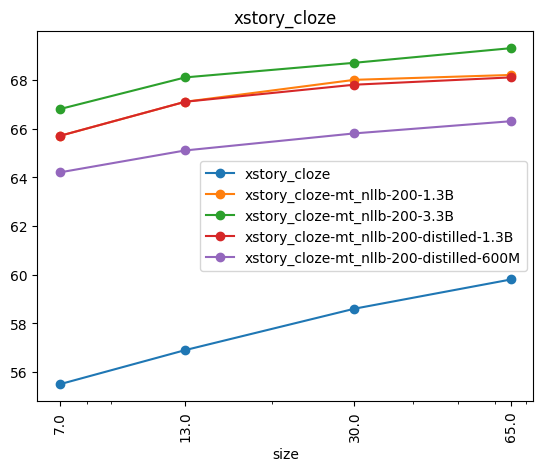

,et,ht,id,it,qu,sw,ta,th,tr,vi,zh,avg,dataset,model,size
llama-7B,48.8,51.0,54.6,62.0,51.4,50.8,55.2,55.8,55.6,51.6,56.2,53.9,xcopa,llama,7.0
llama-13B,48.2,52.8,57.8,67.2,50.2,51.2,54.4,54.6,53.0,53.8,58.4,54.7,xcopa,llama,13.0
llama-30B,47.2,51.8,60.6,71.4,49.4,52.4,53.2,54.6,52.2,52.4,62.2,55.2,xcopa,llama,30.0
llama-65B,48.2,51.6,62.6,72.8,52.2,51.6,51.2,54.8,55.0,54.2,65.8,56.4,xcopa,llama,65.0
llama-7B,69.6,64.2,68.4,70.2,53.4,63.0,65.4,62.4,68.4,66.0,67.6,65.3,xcopa-mt_nllb-200-distilled-600M,llama,7.0
llama-13B,68.4,64.4,71.0,72.4,53.8,64.0,66.8,63.6,68.8,68.0,69.2,66.4,xcopa-mt_nllb-200-distilled-600M,llama,13.0
llama-30B,69.0,65.6,72.6,73.8,55.2,64.2,67.8,64.6,70.6,68.2,70.0,67.4,xcopa-mt_nllb-200-distilled-600M,llama,30.0
llama-65B,69.6,65.6,73.2,73.6,56.6,64.2,68.6,63.0,70.2,70.2,70.4,67.7,xcopa-mt_nllb-200-distilled-600M,llama,65.0
llama-7B,72.6,68.2,71.0,75.4,52.2,67.4,70.2,62.2,72.6,71.2,71.6,68.6,xcopa-mt_nllb-200-3.3B,llama,7.0
llama-13B,73.2,70.0,72.8,76.8,51.6,70.2,71.8,64.8,73.2,75.2,75.2,70.4,xcopa-mt_nllb-200-3.3B,llama,13.0


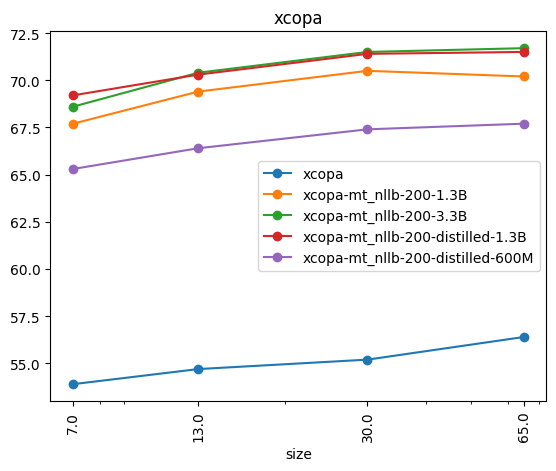

,en,fr,jp,pt,ru,zh,avg,dataset,model,size
llama-7B,84.9,72.3,58.9,70.7,64.4,63.7,69.2,xwinograd,llama,7.0
llama-13B,86.8,68.7,59.9,71.5,70.8,70.0,71.3,xwinograd,llama,13.0
llama-30B,87.4,73.5,67.4,76.8,67.0,71.2,73.9,xwinograd,llama,30.0
llama-65B,87.2,78.3,64.1,74.9,72.7,74.8,75.3,xwinograd,llama,65.0


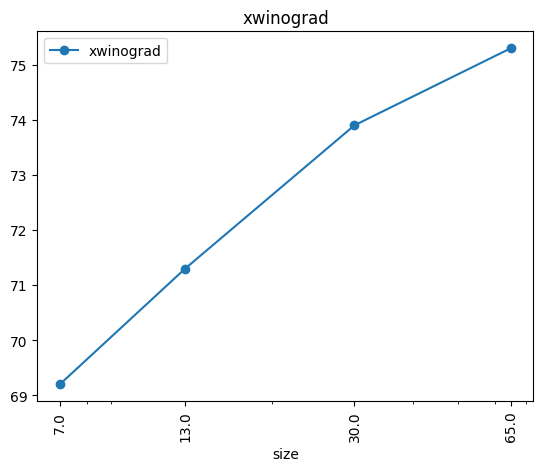

,ar,bg,de,el,en,es,fr,hi,ru,sw,th,tr,ur,vi,zh,avg,dataset,model,size
llama-7B,33.6,37.0,44.8,34.9,51.1,40.6,43.8,36.1,39.4,33.7,34.5,35.6,33.4,35.6,36.2,38.0,xnli,llama,7.0
llama-13B,34.1,34.2,35.2,34.7,35.6,33.5,33.5,35.6,33.8,33.2,34.8,34.0,34.2,34.2,34.5,34.3,xnli,llama,13.0
llama-30B,34.5,38.5,43.9,34.9,48.2,40.2,43.0,36.5,38.1,34.1,34.0,36.5,34.3,35.7,33.5,37.7,xnli,llama,30.0
llama-65B,33.5,45.3,48.9,39.2,55.9,49.9,52.0,42.6,48.3,35.8,37.0,41.2,37.1,38.8,33.7,42.6,xnli,llama,65.0
llama-7B,48.6,49.3,49.9,50.1,NaN,50.4,50.1,48.5,48.3,46.5,46.4,48.0,45.5,49.2,49.3,48.6,xnli-mt_nllb-200-3.3B,llama,7.0
llama-13B,34.1,35.5,35.2,35.4,NaN,35.2,35.3,35.4,35.1,35.1,34.0,34.5,35.1,34.8,35.9,35.0,xnli-mt_nllb-200-3.3B,llama,13.0
llama-30B,46.2,46.3,47.0,47.0,NaN,47.7,47.3,45.8,46.1,44.7,44.8,45.3,44.0,46.4,46.6,46.1,xnli-mt_nllb-200-3.3B,llama,30.0
llama-65B,52.5,53.0,53.3,54.1,NaN,54.2,53.0,51.2,52.2,50.3,50.3,52.6,48.0,52.2,52.4,52.1,xnli-mt_nllb-200-3.3B,llama,65.0
llama-7B,48.0,49.0,49.9,49.5,NaN,51.3,48.9,47.4,48.6,47.1,47.2,48.5,45.7,48.5,48.8,48.5,xnli-mt_nllb-200-distilled-600M,llama,7.0
llama-13B,34.3,35.8,35.4,35.5,NaN,35.0,35.2,35.6,34.8,34.5,34.6,33.8,34.9,35.0,35.2,35.0,xnli-mt_nllb-200-distilled-600M,llama,13.0


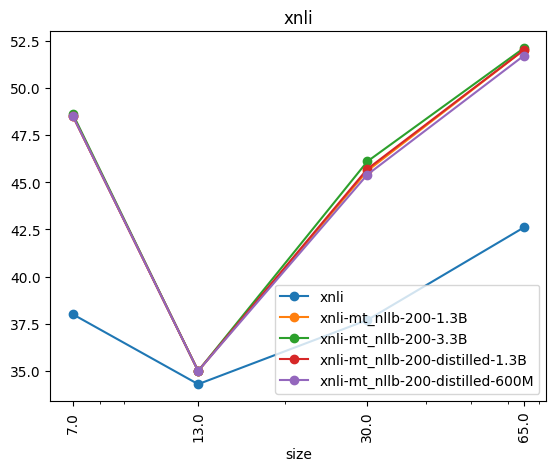

,de,en,es,fr,ja,ko,zh,avg,dataset,model,size
llama-7B,54.6,61.9,56.1,52.9,56.7,49.7,49.1,54.4,pawsx,llama,7.0
llama-13B,52.9,53.7,52.1,54.5,45.0,47.0,45.2,50.1,pawsx,llama,13.0
llama-30B,58.2,58.8,55.8,52.8,46.8,45.7,45.9,52.0,pawsx,llama,30.0
llama-65B,64.2,67.7,65.6,58.1,58.4,57.4,51.9,60.5,pawsx,llama,65.0
llama-7B,60.1,NaN,60.7,59.7,57.3,55.5,57.5,58.5,pawsx-mt_nllb-200-distilled-600M,llama,7.0
llama-13B,52.8,NaN,53.4,53.0,54.3,53.2,54.0,53.4,pawsx-mt_nllb-200-distilled-600M,llama,13.0
llama-30B,57.2,NaN,56.6,56.3,54.0,54.1,53.6,55.3,pawsx-mt_nllb-200-distilled-600M,llama,30.0
llama-65B,66.7,NaN,65.1,65.5,57.9,57.7,60.1,62.2,pawsx-mt_nllb-200-distilled-600M,llama,65.0
llama-7B,59.9,NaN,60.6,60.1,57.6,57.5,57.3,58.8,pawsx-mt_nllb-200-3.3B,llama,7.0
llama-13B,53.6,NaN,54.7,53.6,55.9,54.5,53.9,54.4,pawsx-mt_nllb-200-3.3B,llama,13.0


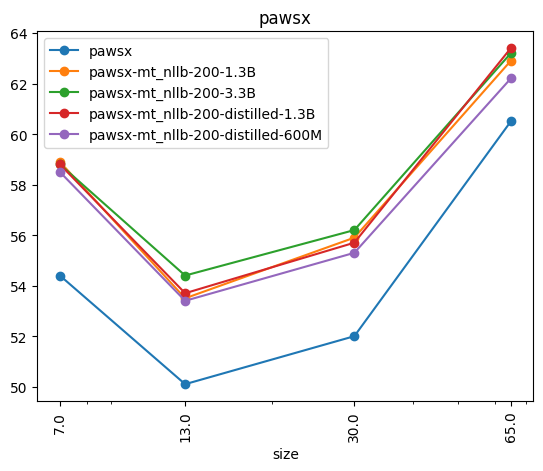

,bn,de,en,es,fr,ja,ru,sw,te,th,zh,avg,dataset,model,size
llama-7B,0.0,9.6,13.6,10.4,8.8,5.2,10.0,2.0,0.0,0.0,4.4,5.8,mgsm,llama,7.0
llama-13B,0.0,16.0,20.8,15.2,15.6,5.2,10.0,3.6,0.0,0.0,8.8,8.7,mgsm,llama,13.0
llama-30B,0.0,29.2,39.6,33.2,30.4,7.2,27.2,5.2,0.0,0.0,22.8,17.7,mgsm,llama,30.0
llama-65B,0.0,40.8,56.4,44.0,44.0,18.8,36.0,9.6,0.0,0.0,25.6,25.0,mgsm,llama,65.0
llama-7B,5.6,9.2,NaN,8.4,10.4,6.8,9.2,7.2,8.8,8.0,5.2,7.9,mgsm-mt_nllb-200-distilled-600M,llama,7.0
llama-13B,12.4,16.0,NaN,12.4,15.6,8.4,14.0,12.4,12.0,10.8,10.4,12.4,mgsm-mt_nllb-200-distilled-600M,llama,13.0
llama-30B,11.2,27.6,NaN,23.6,22.8,12.4,18.0,16.4,17.6,16.4,21.6,18.8,mgsm-mt_nllb-200-distilled-600M,llama,30.0
llama-65B,17.6,39.6,NaN,35.2,33.2,15.6,27.6,25.2,32.0,22.0,30.8,27.9,mgsm-mt_nllb-200-distilled-600M,llama,65.0
llama-7B,10.0,12.4,NaN,12.0,9.6,10.8,10.8,12.0,9.6,8.4,11.2,10.7,mgsm-mt_nllb-200-3.3B,llama,7.0
llama-13B,16.8,20.0,NaN,20.8,15.2,15.2,15.6,19.2,14.0,14.0,14.4,16.5,mgsm-mt_nllb-200-3.3B,llama,13.0


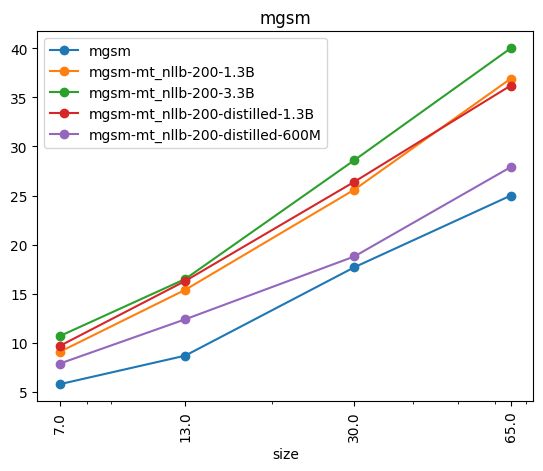

In [48]:
dfs_xglm = get_dataframes_model(all_results, datasets, "llama")

for df in dfs_xglm:
    display(df)
    plot_size_df_datasets(df, "llama")